<a href="https://colab.research.google.com/github/KangGao1997/Donkey_car/blob/main/Neuro_AI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Stringer spontaneous data

includes some visualizations

In [ ]:
# @title Install dependencies
!pip install umap-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (11983 by 7018). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [ ]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(11983, 7018)
11983


In [ ]:
dat['run'].shape

(7018, 1)

In [ ]:
dat['xyz'].shape
x, y, z = dat['xyz']

In [ ]:
z

array([-150., -150., -150., ..., -390., -390., -390.])

In [ ]:
zunq, iunq = np.unique(z, return_inverse=True)
zunq,iunq

(array([-390., -360., -330., -300., -270., -240., -210., -180., -150.]),
 array([8, 8, 8, ..., 0, 0, 0]))

In [ ]:
dat['pupilCOM'].shape

(7018, 2)

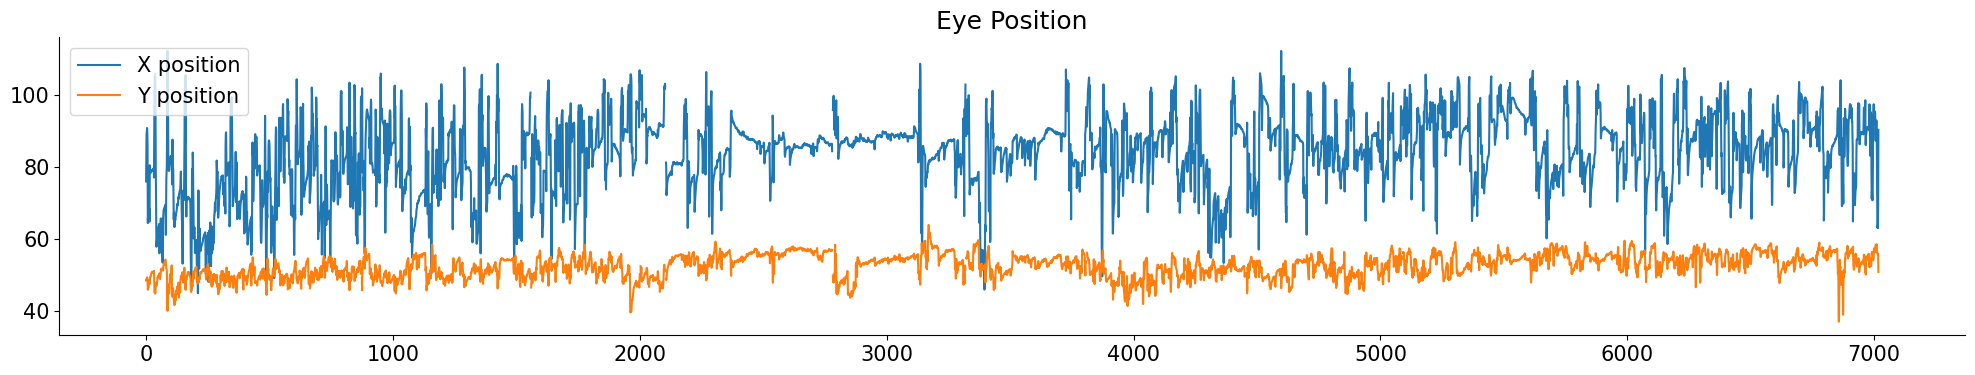

In [ ]:
plt.figure()
plt.plot(dat['pupilCOM'][:,0], label = 'X position')
plt.plot(dat['pupilCOM'][:,1], label = 'Y position')
plt.title("Eye Position")
plt.legend()

<ipython-input-11-749e88150ef0>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


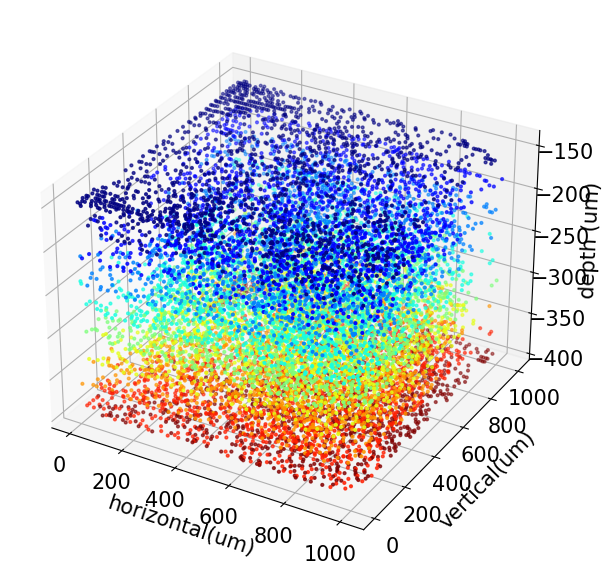

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')
plt.show()

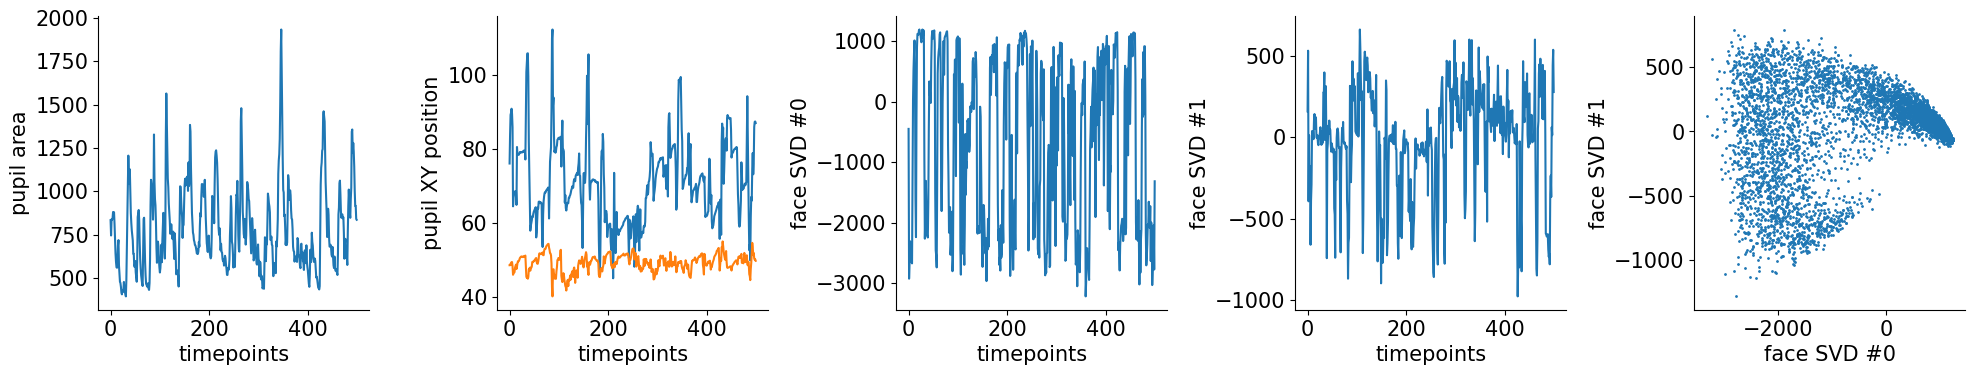

In [ ]:
# @title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupilArea'][:500, 0])
ax.set(xlabel='timepoints', ylabel='pupil area')

ax = plt.subplot(1, 5, 2)
plt.plot(dat['pupilCOM'][:500, :])
ax.set(xlabel='timepoints', ylabel='pupil XY position')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['beh_svd_time'][:500, 0])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['beh_svd_time'][:500, 1])
ax.set(xlabel='timepoints', ylabel='face SVD #1')

ax = plt.subplot(1, 5, 5)
plt.scatter(dat['beh_svd_time'][:, 0], dat['beh_svd_time'][:, 1], s=1)
ax.set(xlabel='face SVD #0', ylabel='face SVD #1')

plt.show()

In [ ]:
# @title take PCA after preparing data by z-score

Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components=200).fit_transform(Z)

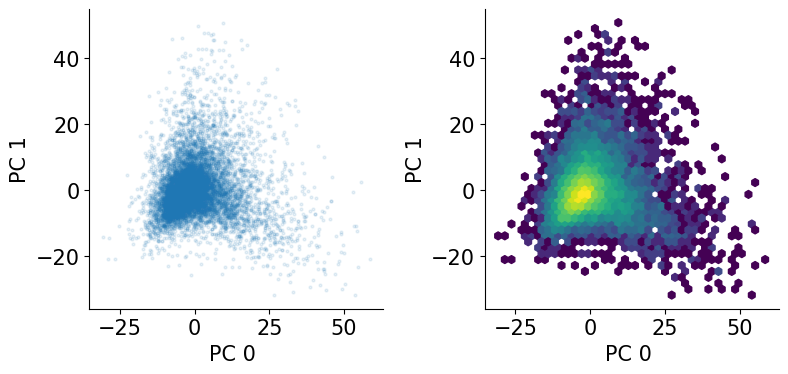

In [ ]:
# @title Plot PCs. Too many points, switch to logarithmic hexbin!
ax = plt.subplot(1, 5, 1)
plt.scatter(X[:, 0], X[:, 1], s=4, alpha=.1)
ax.set(xlabel='PC 0 ', ylabel='PC 1')

ax = plt.subplot(1, 5, 2)
plt.hexbin(X[:, 0], X[:, 1], gridsize=40, bins='log')
ax.set(xlabel='PC 0 ', ylabel='PC 1', alpha=.1)

plt.show()

In [ ]:
# @title run a manifold embedding algorithm (UMAP) in two or three dimensions.

ncomp = 1 # try 2, then try 3
xinit = 1 * zscore(X[:, :ncomp], axis=0)
embed = UMAP(n_components=ncomp, init=xinit, n_neighbors=20,
             metric='correlation', transform_seed=42).fit_transform(X)

In [ ]:
embed = embed.flatten()
isort = np.argsort(embed)
RasterMap = uniform_filter1d(Z[isort, :], size=50, axis=0)
RasterMap = zscore(RasterMap[::10, :], axis=1)

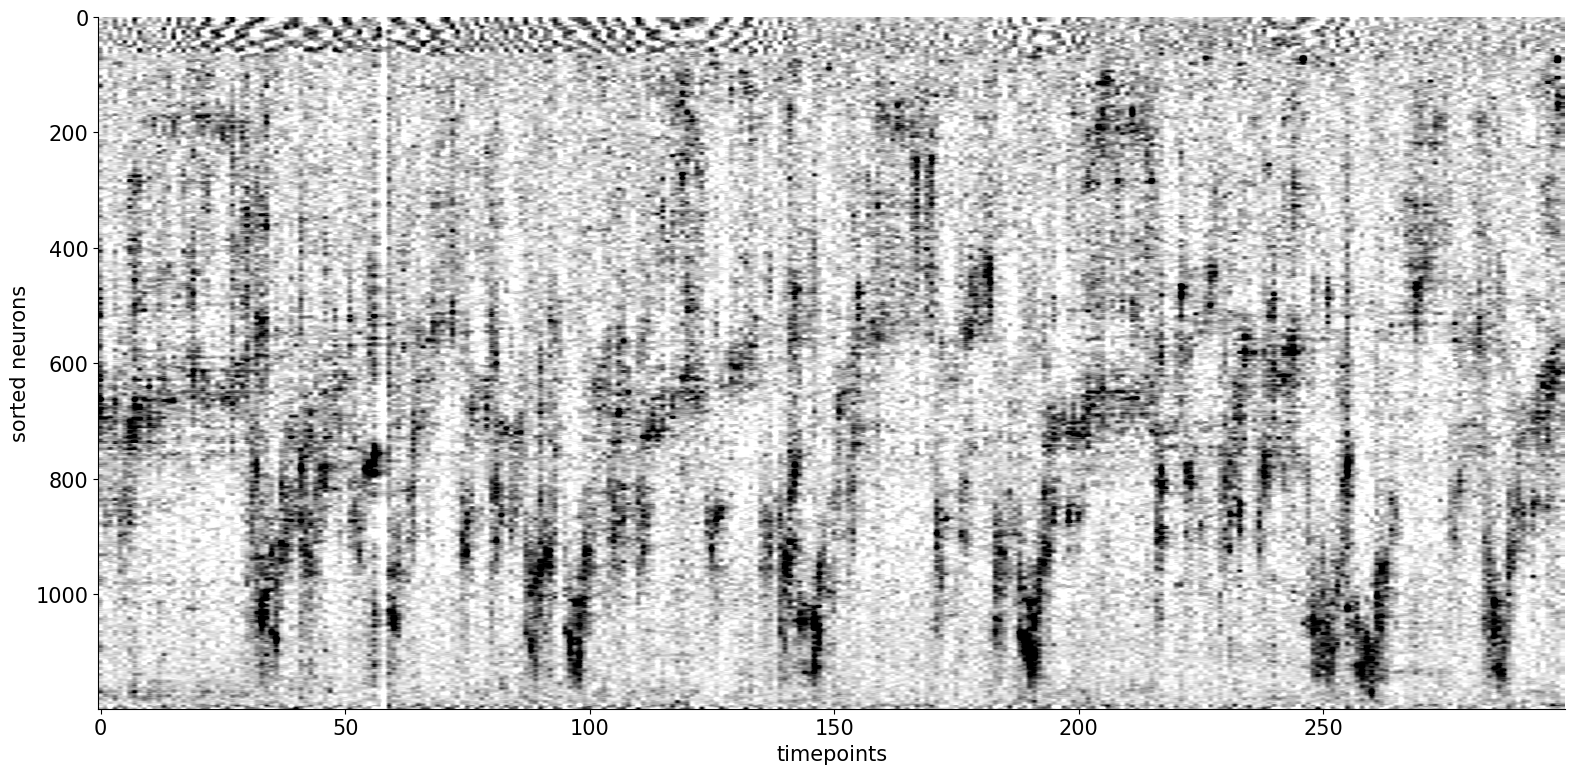

In [ ]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
trange = np.arange(1100, 1400)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin=-1, aspect='auto', cmap='gray_r')
ax.set(xlabel='timepoints', ylabel='sorted neurons')
plt.show()

In [ ]:
# now sort with UMAP both the neuron axis and the timepoints axis, bin the sorted matrix and make a sorted Rastermap picture

# play around with pupil area

In [ ]:
# what is the shape/size/format of neural activity?

dat['sresp'].shape

(11983, 7018)

In [ ]:
dat['pupilArea'].shape

(7018, 1)

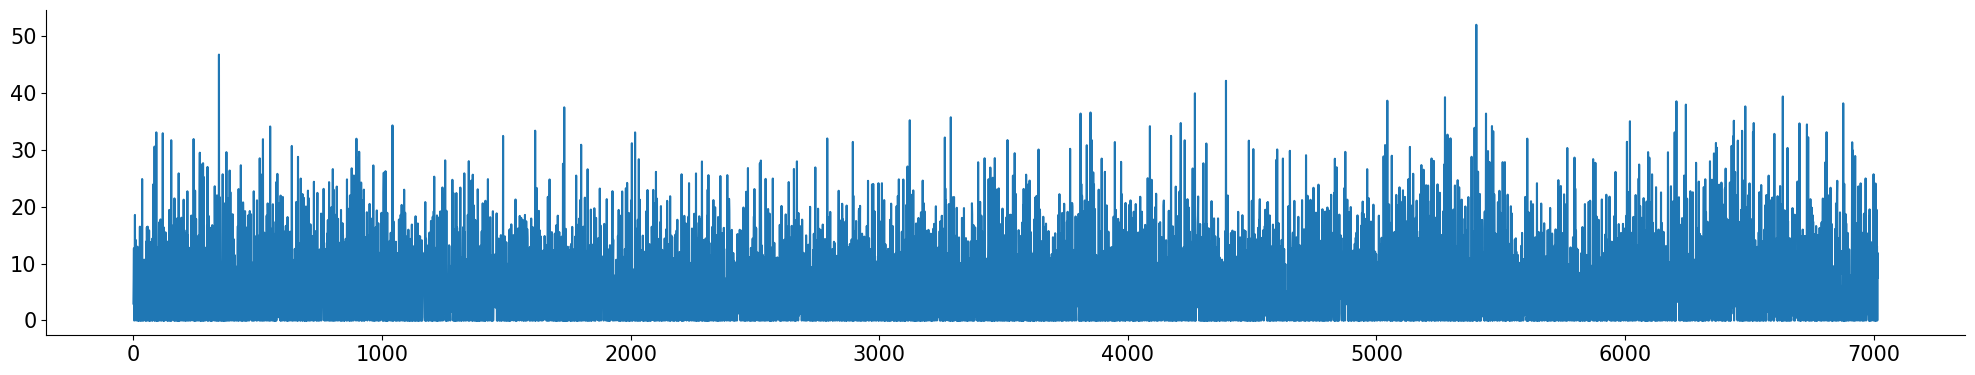

In [ ]:
plt.plot(dat['sresp'][0])

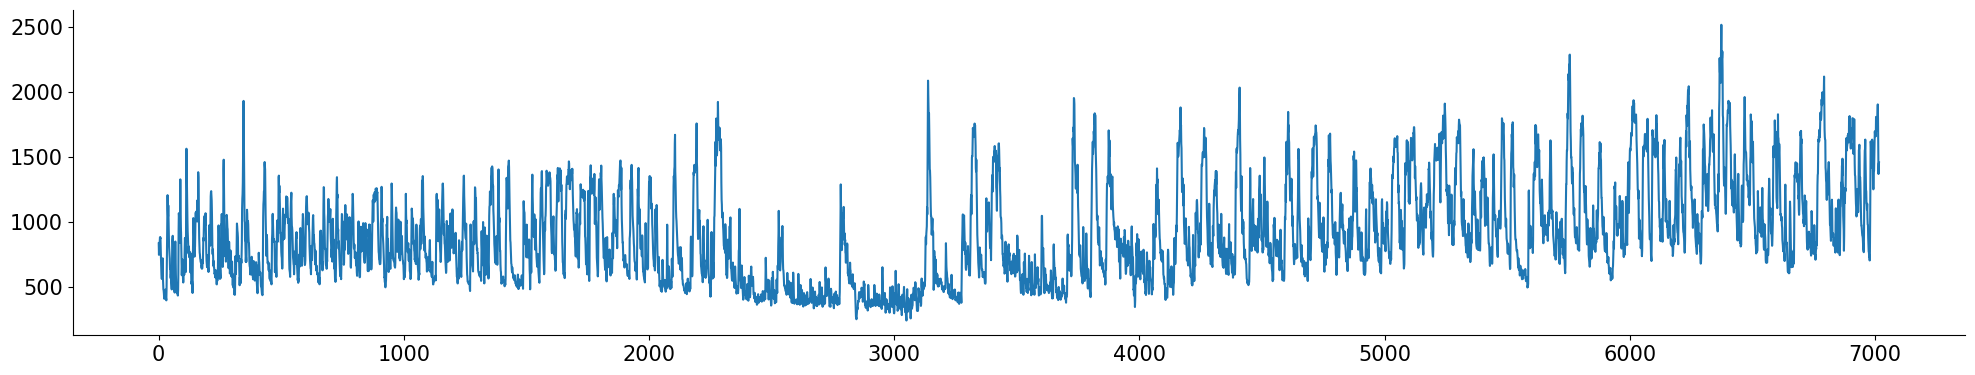

In [ ]:
plt.plot(dat['pupilArea'])

## Train a linear regressor

In [ ]:
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [ ]:
train_neural_activity = dat['sresp'][:,0:5000].T
train_pupil_area = dat['pupilArea'][0:5000]
train_neural_activity.shape, train_pupil_area.shape

((5000, 11983), (5000, 1))

In [ ]:
Scaler = StandardScaler()
train_pupil_area =  Scaler.fit_transform(train_pupil_area)

In [ ]:
linear_decoder_pupilArea = Pipeline([('Scaler',StandardScaler()),
                                     ('pca',PCA(n_components=1000)),
                                    ('linear_regressor', LinearRegression())])

In [ ]:
linear_decoder_pupilArea = linear_decoder_pupilArea.fit(train_neural_activity,train_pupil_area)

### test on training dataset

In [ ]:
pred_train_pupil_area = linear_decoder_pupilArea.predict(train_neural_activity)

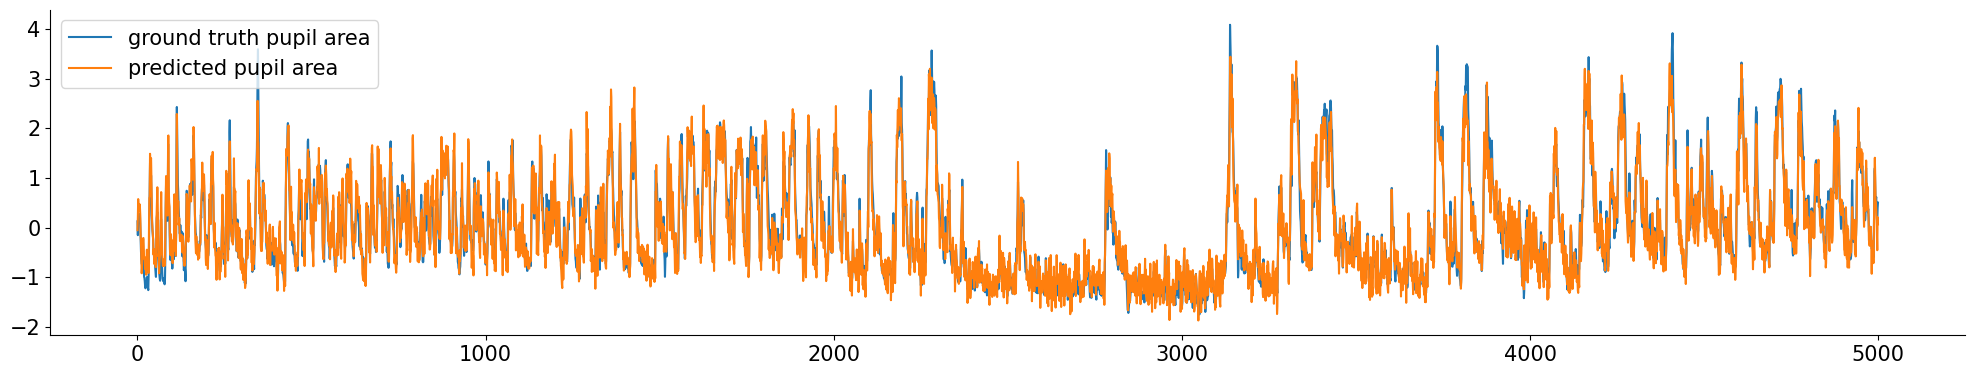

In [ ]:
plt.figure()
plt.plot(train_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_train_pupil_area, label = 'predicted pupil area')
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
print("mean square error on training dataset: ", mean_squared_error(pred_train_pupil_area,train_pupil_area))

mean square error on training dataset:  0.07598224212274414


### test on testing dataset

In [ ]:
test_neural_activity = dat['sresp'][:,5000:].T
test_pupil_area = dat['pupilArea'][5000:]
test_neural_activity.shape, test_pupil_area.shape

((2018, 11983), (2018, 1))

In [ ]:
test_pupil_area = Scaler.transform(test_pupil_area)

In [ ]:
pred_test_pupil_area = linear_decoder_pupilArea.predict(test_neural_activity)

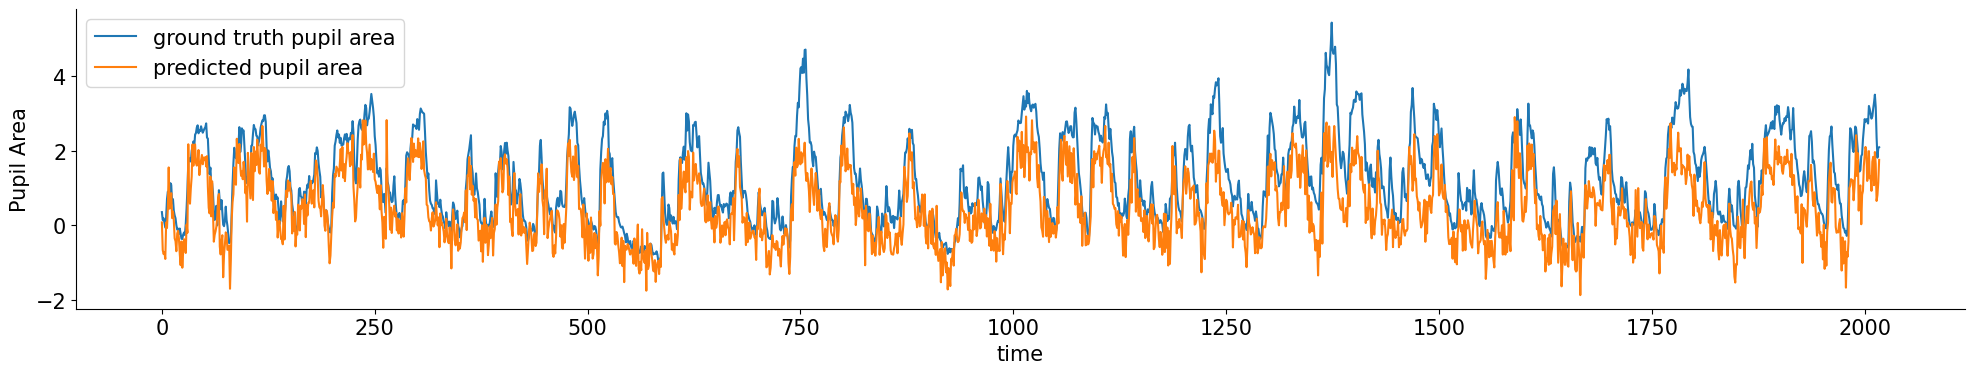

In [ ]:
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.xlabel("time")
plt.ylabel("Pupil Area")
plt.legend()

In [ ]:
print("mean square error on training dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

mean square error on training dataset:  0.6347932462984759


The performance is not very good, seems like overfitting

## Train a Ridge regressor

In [ ]:
ridge_decoder_pupilArea = Pipeline([('Scaler',StandardScaler()),
                                    ('pca',PCA(n_components=1000)),
                                    ('ridge_regressor', Ridge())])

In [ ]:
#ridge_decoder_pupilArea.fit(train_neural_activity,train_pupil_area)

ridge_decoder_pupilArea.get_params()

{'memory': None,
 'steps': [('Scaler', StandardScaler()),
  ('pca', PCA(n_components=1000)),
  ('ridge_regressor', Ridge())],
 'verbose': False,
 'Scaler': StandardScaler(),
 'pca': PCA(n_components=1000),
 'ridge_regressor': Ridge(),
 'Scaler__copy': True,
 'Scaler__with_mean': True,
 'Scaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 1000,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'ridge_regressor__alpha': 1.0,
 'ridge_regressor__copy_X': True,
 'ridge_regressor__fit_intercept': True,
 'ridge_regressor__max_iter': None,
 'ridge_regressor__positive': False,
 'ridge_regressor__random_state': None,
 'ridge_regressor__solver': 'auto',
 'ridge_regressor__tol': 0.0001}

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'ridge_regressor__alpha': [1300,1400,1500]}
Ridge_pupil_area_gs = GridSearchCV(ridge_decoder_pupilArea,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)

Ridge_pupil_area_gs.fit(train_neural_activity,train_pupil_area)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('pca', PCA(n_components=1000)),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
Ridge_pupil_area_gs.best_estimator_

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

In [ ]:
Ridge_decoder_pupilArea = Ridge_pupil_area_gs.best_estimator_


### Testing on train Dataset

In [ ]:
pred_train_pupil_area = Ridge_decoder_pupilArea.predict(train_neural_activity)

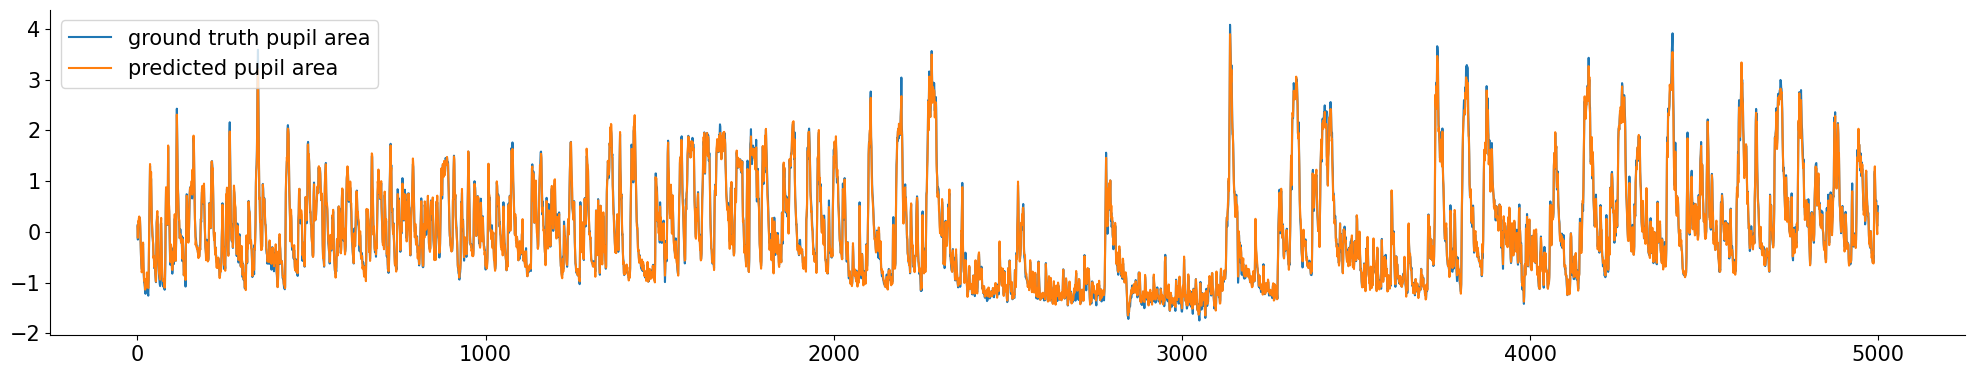

In [ ]:
plt.figure()
plt.plot(train_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_train_pupil_area, label = 'predicted pupil area')
plt.legend()

In [ ]:
print("mean square error on training dataset: ", mean_squared_error(pred_train_pupil_area,train_pupil_area))

mean square error on training dataset:  0.004541158243863491


### Test on Testing dataset

In [ ]:
pred_test_pupil_area = Ridge_decoder_pupilArea.predict(test_neural_activity)

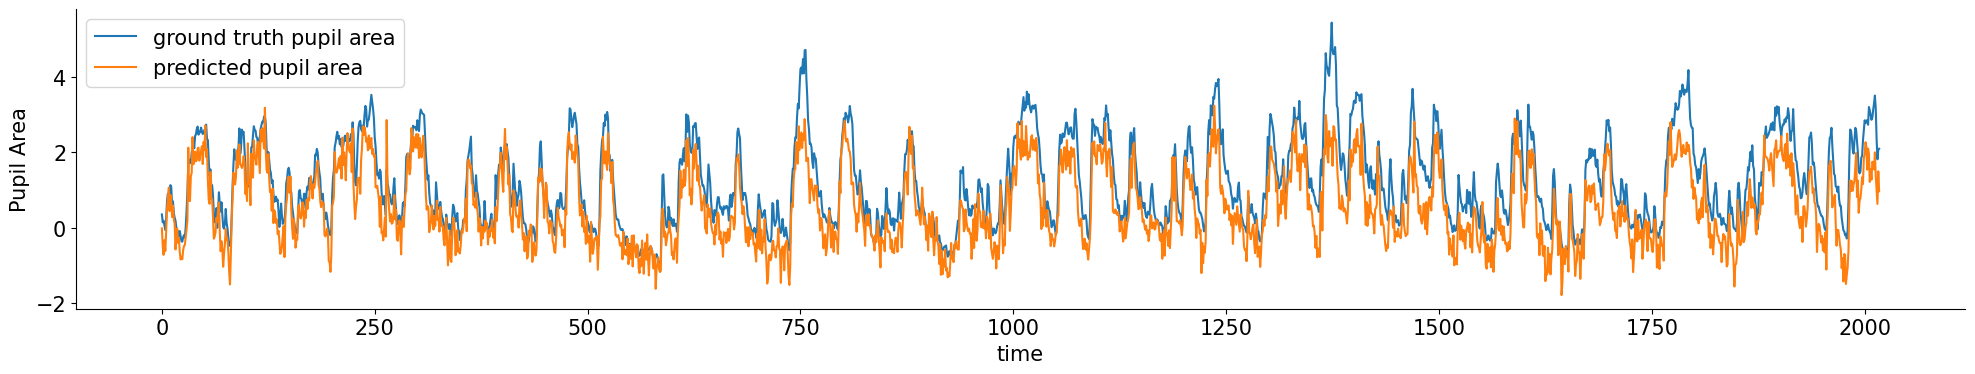

In [ ]:

plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.xlabel("time")
plt.ylabel("Pupil Area")
plt.legend()

In [ ]:
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

mean square error on testing dataset:  0.619636162280601


In [ ]:
w = Ridge_decoder_pupilArea.named_steps['ridge_regressor'].coef_.T
np.mean(w)+np.std(w)

0.0023876117

In [ ]:
dat['xyz'].T.shape

(11983, 3)

<ipython-input-315-02b7e2c35289>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')(xc)


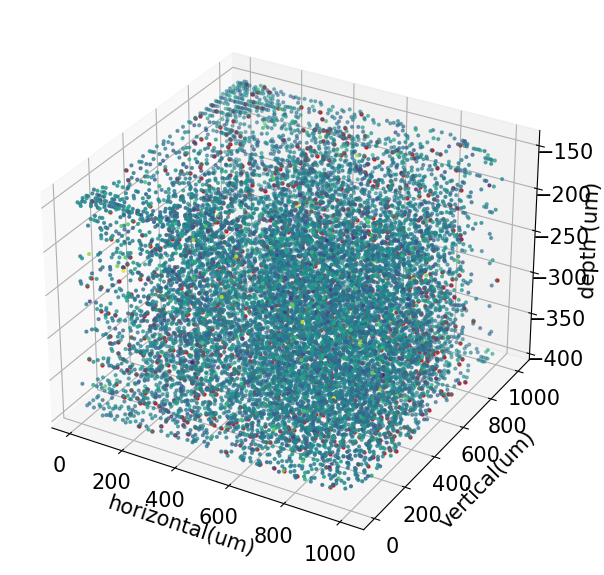

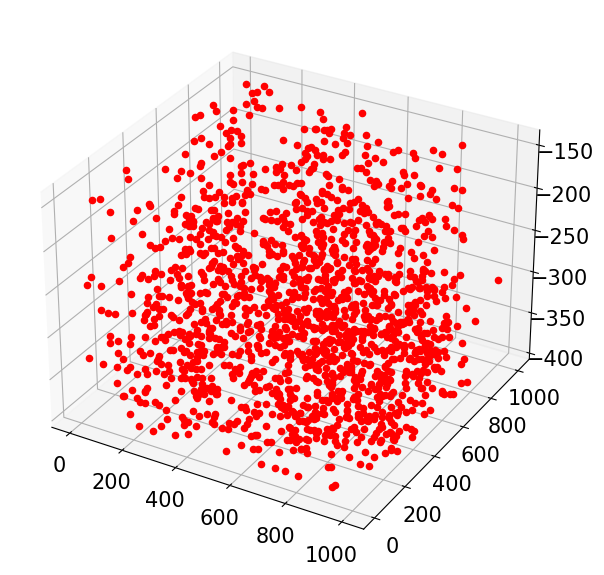

1577

In [ ]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0, 1.0, len(w))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1], z[::-1], 'o', s=4, c=w)
ax.set(xlabel='horizontal(um)', ylabel='vertical(um)', zlabel='depth (um)')

for i in range(w.shape[0]):
  if np.abs(w[i])>(np.mean(np.abs(w)) + np.std(np.abs(w))):
    ax.scatter(x[i],y[i], z[i], 'o', s=4, c='r')
#plt.colorbar()
plt.show()
count = 0
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(w.shape[0]):
  if np.abs(w[i])>(np.mean(np.abs(w)) + np.std(np.abs(w))):
    ax.scatter(x[i],y[i], z[i], c = 'r')
    count += 1
plt.show()

count

### Explore different depth

In [ ]:
np.unique(dat['xyz'][2],return_counts = False, return_index = True)

(array([-390., -360., -330., -300., -270., -240., -210., -180., -150.]),
 array([10597,  9157,  7739,  6268,  4853,  3532,  2314,  1131,     0]))

There are 7 depths



In [ ]:
##seperate neuron according to depth
neural_activity_390 = dat['sresp'][9158:10598]
neural_activity_360 = dat['sresp'][7740:9158]
neural_activity_330 = dat['sresp'][6269:7740]
neural_activity_300 = dat['sresp'][4864:6269]
neural_activity_270 = dat['sresp'][3533:4864]
neural_activity_240 = dat['sresp'][2315:3533]
neural_activity_210 = dat['sresp'][2315:3533]
neural_activity_180 = dat['sresp'][1132:2315]
neural_activity_150 = dat['sresp'][0:1132]

#### 390

In [ ]:
train_neural_activity_390 = neural_activity_390.T[0:5000]
train_neural_activity_390.shape

(5000, 1440)

In [ ]:
test_neural_activity_390 = neural_activity_390.T[5000:]
test_neural_activity_390.shape

(2018, 1440)

In [ ]:
ridge_decoder_pupilArea_390 = Pipeline([('Scaler',StandardScaler()),
                                        ('pca',PCA(n_components=1000)),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_390 = GridSearchCV(ridge_decoder_pupilArea_390,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_390.fit(train_neural_activity_390,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_390 = Ridge_pupil_area_gs_390.best_estimator_
ridge_pupil_area_390

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  0.955100971516492


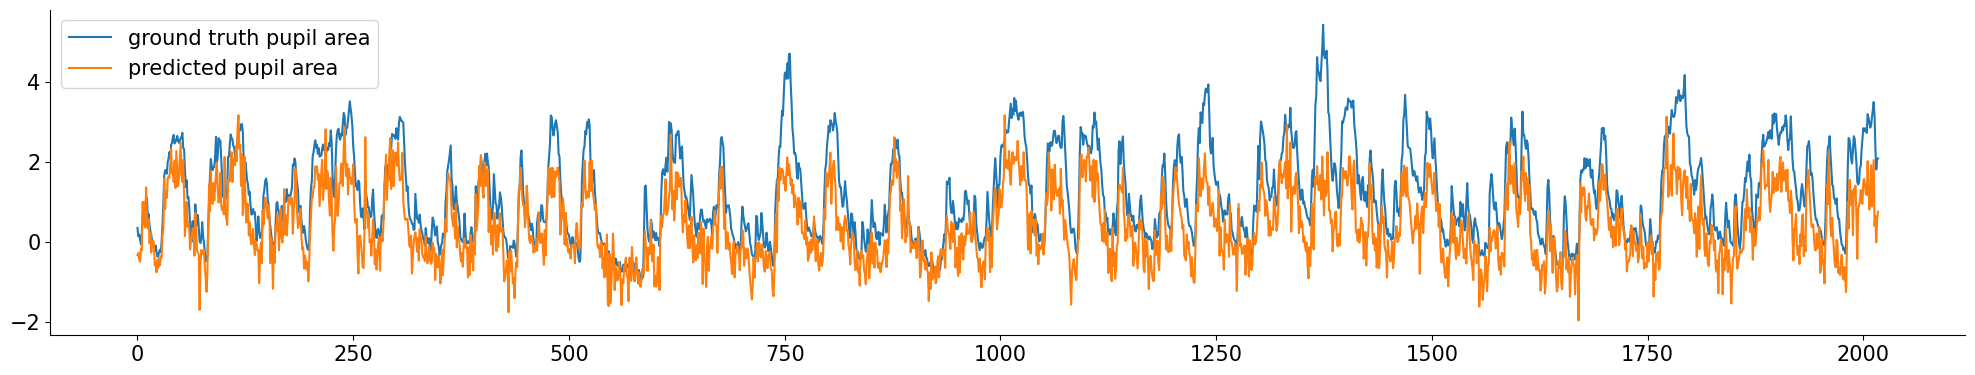

In [ ]:
pred_test_pupil_area = ridge_pupil_area_390.predict(test_neural_activity_390)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 360

In [ ]:
train_neural_activity_360 = neural_activity_360.T[0:5000]
train_neural_activity_360.shape

(5000, 1418)

In [ ]:
test_neural_activity_360 = neural_activity_360.T[5000:]
test_neural_activity_360.shape

(2018, 1418)

In [ ]:
ridge_decoder_pupilArea_360 = Pipeline([('Scaler',StandardScaler()),
                                        ('pca',PCA(n_components=1000)),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_360 = GridSearchCV(ridge_decoder_pupilArea_360,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_360.fit(train_neural_activity_360,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_360 = Ridge_pupil_area_gs_360.best_estimator_
ridge_pupil_area_360

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset (360):  0.8936967280031408


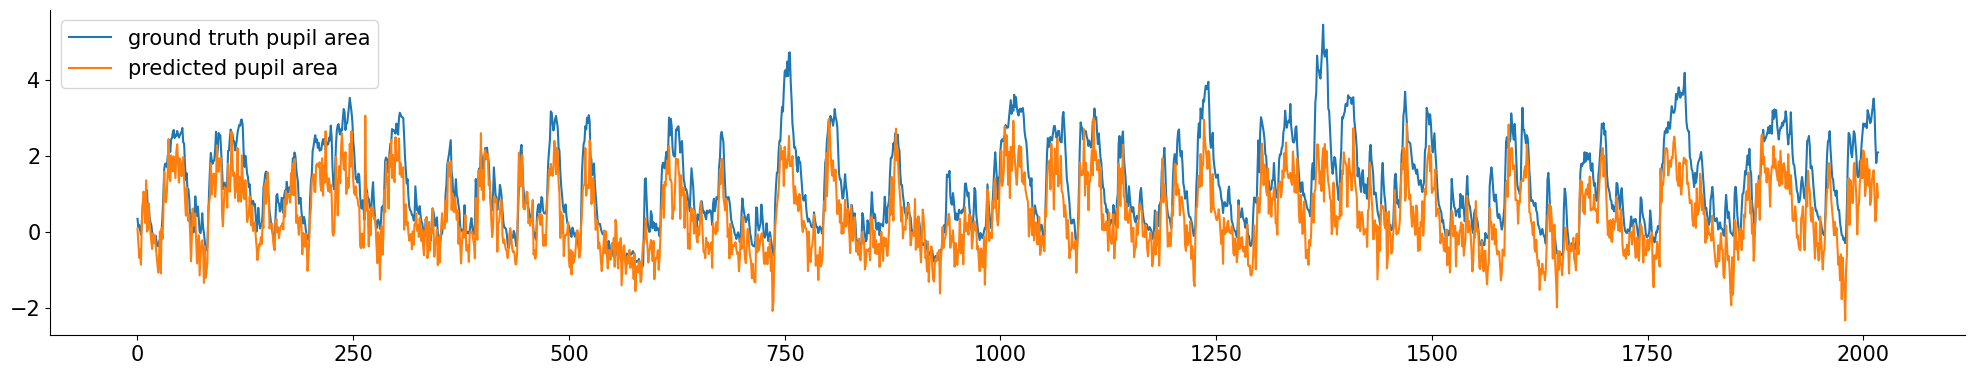

In [ ]:
pred_test_pupil_area = ridge_pupil_area_360.predict(test_neural_activity_360)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset (360): ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 330

In [ ]:
train_neural_activity_330 = neural_activity_330.T[0:5000]
train_neural_activity_330.shape

(5000, 1471)

In [ ]:
test_neural_activity_330 = neural_activity_330.T[5000:]
test_neural_activity_330.shape

(2018, 1471)

In [ ]:
ridge_decoder_pupilArea_330 = Pipeline([('Scaler',StandardScaler()),
                                        ('pca',PCA(n_components=1000)),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_330 = GridSearchCV(ridge_decoder_pupilArea_330,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_330.fit(train_neural_activity_330,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_330 = Ridge_pupil_area_gs_330.best_estimator_
ridge_pupil_area_330

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  0.8897411942590568


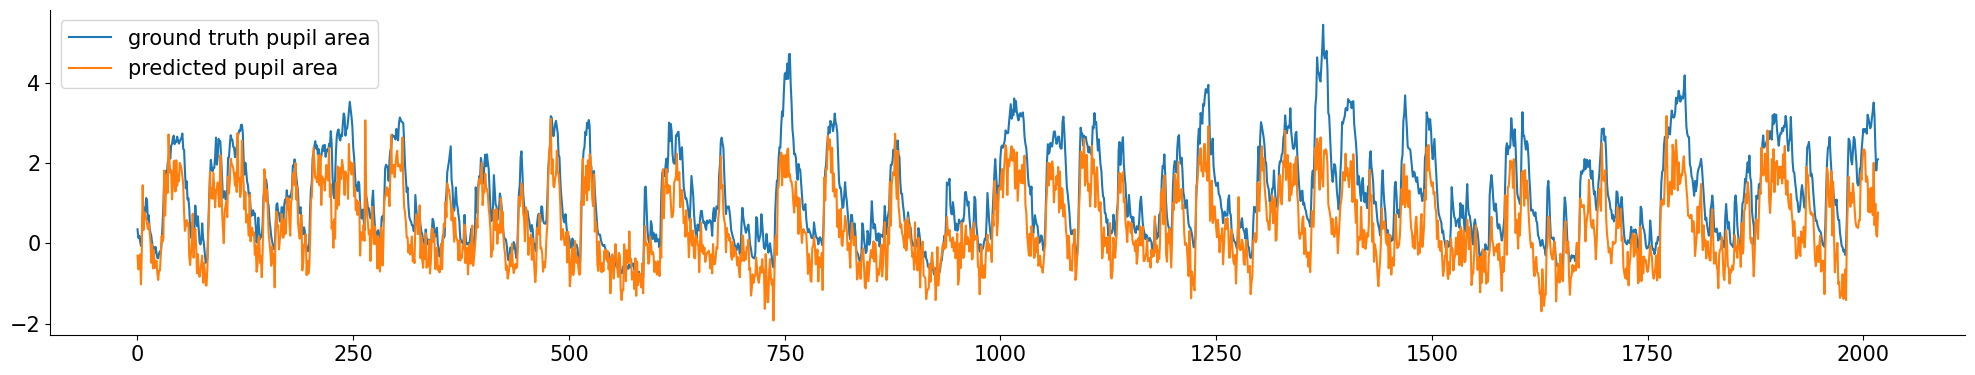

In [ ]:
pred_test_pupil_area = ridge_pupil_area_330.predict(test_neural_activity_330)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 300

In [ ]:
train_neural_activity_300 = neural_activity_300.T[0:5000]
train_neural_activity_300.shape

(5000, 1405)

In [ ]:
test_neural_activity_300 = neural_activity_300.T[5000:]
test_neural_activity_300.shape

(2018, 1405)

In [ ]:
ridge_decoder_pupilArea_300 = Pipeline([('Scaler',StandardScaler()),
                                        ('pca',PCA(n_components=1000)),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_300 = GridSearchCV(ridge_decoder_pupilArea_300,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_300.fit(train_neural_activity_300,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_300 = Ridge_pupil_area_gs_300.best_estimator_
ridge_pupil_area_300

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  0.9056728060760459


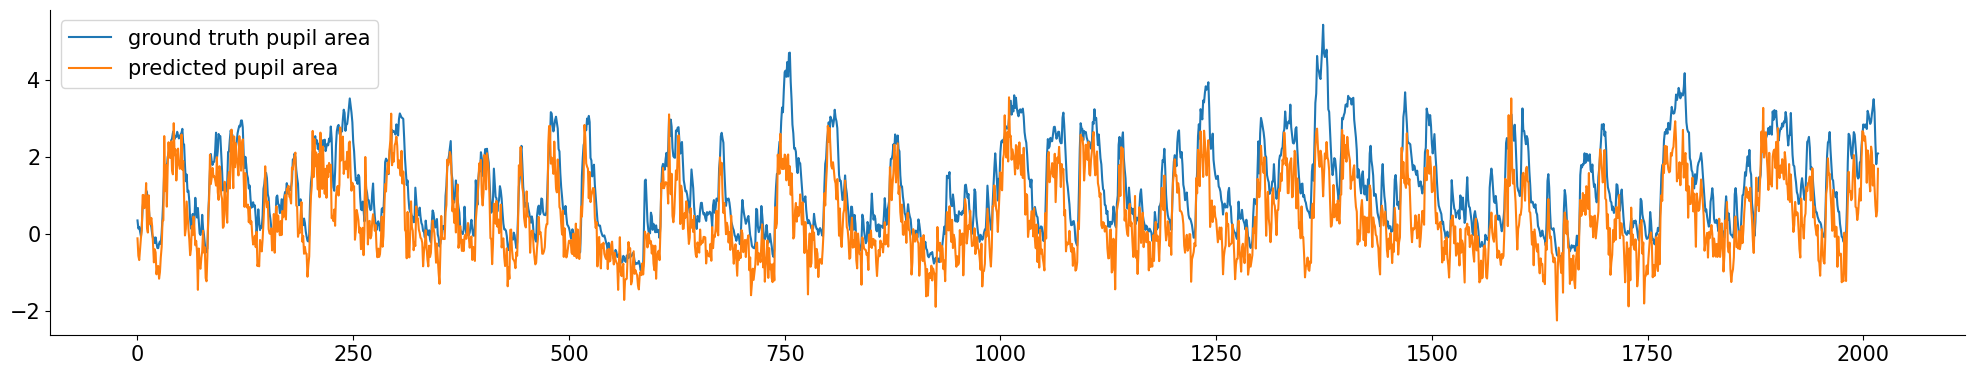

In [ ]:
pred_test_pupil_area = ridge_pupil_area_300.predict(test_neural_activity_300)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 270

In [ ]:
train_neural_activity_270 = neural_activity_270.T[0:5000]
train_neural_activity_270.shape

(5000, 1331)

In [ ]:
test_neural_activity_270 = neural_activity_270.T[5000:]
test_neural_activity_270.shape

(2018, 1331)

In [ ]:
ridge_decoder_pupilArea_270 = Pipeline([('Scaler',StandardScaler()),
                                        ('pca',PCA(n_components=1000)),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_270 = GridSearchCV(ridge_decoder_pupilArea_270,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_270.fit(train_neural_activity_270,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_270 = Ridge_pupil_area_gs_270.best_estimator_
ridge_pupil_area_270

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  0.928620335701669


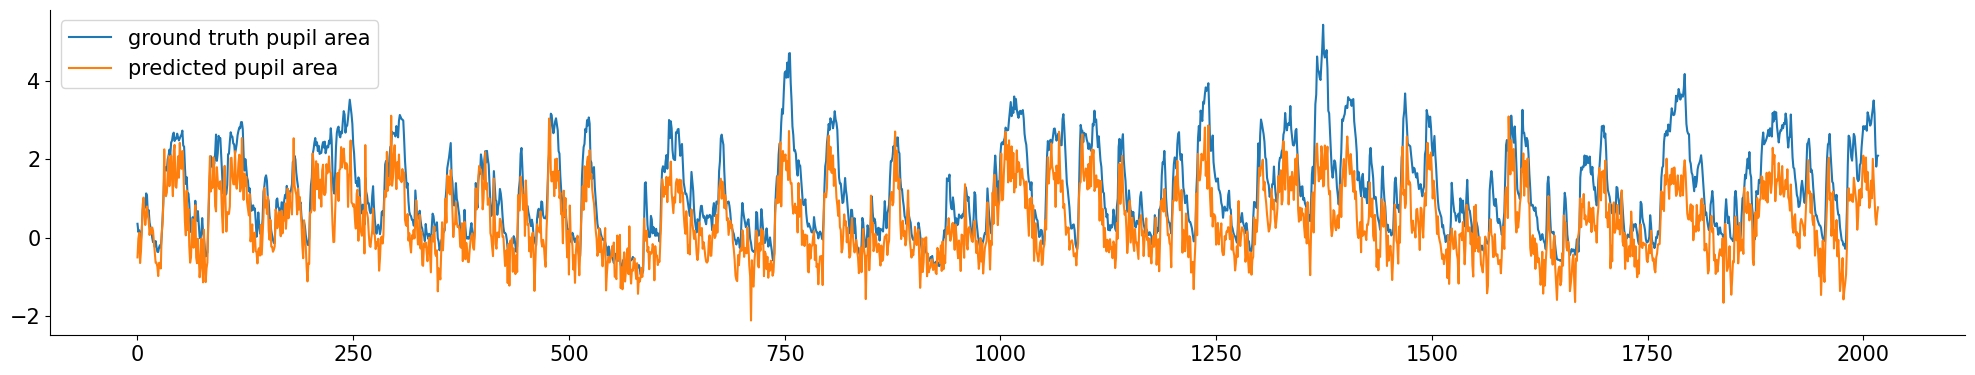

In [ ]:
pred_test_pupil_area = ridge_pupil_area_270.predict(test_neural_activity_270)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 240

In [ ]:
train_neural_activity_240 = neural_activity_240.T[0:5000]
train_neural_activity_240.shape

(5000, 1218)

In [ ]:
test_neural_activity_240 = neural_activity_240.T[5000:]
test_neural_activity_240.shape

(2018, 1218)

In [ ]:
ridge_decoder_pupilArea_240 = Pipeline([('Scaler',StandardScaler()),
                                        ('pca',PCA(n_components=1000)),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_240 = GridSearchCV(ridge_decoder_pupilArea_240,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_240.fit(train_neural_activity_240,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_240 = Ridge_pupil_area_gs_240.best_estimator_
ridge_pupil_area_240

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  1.039608420591259


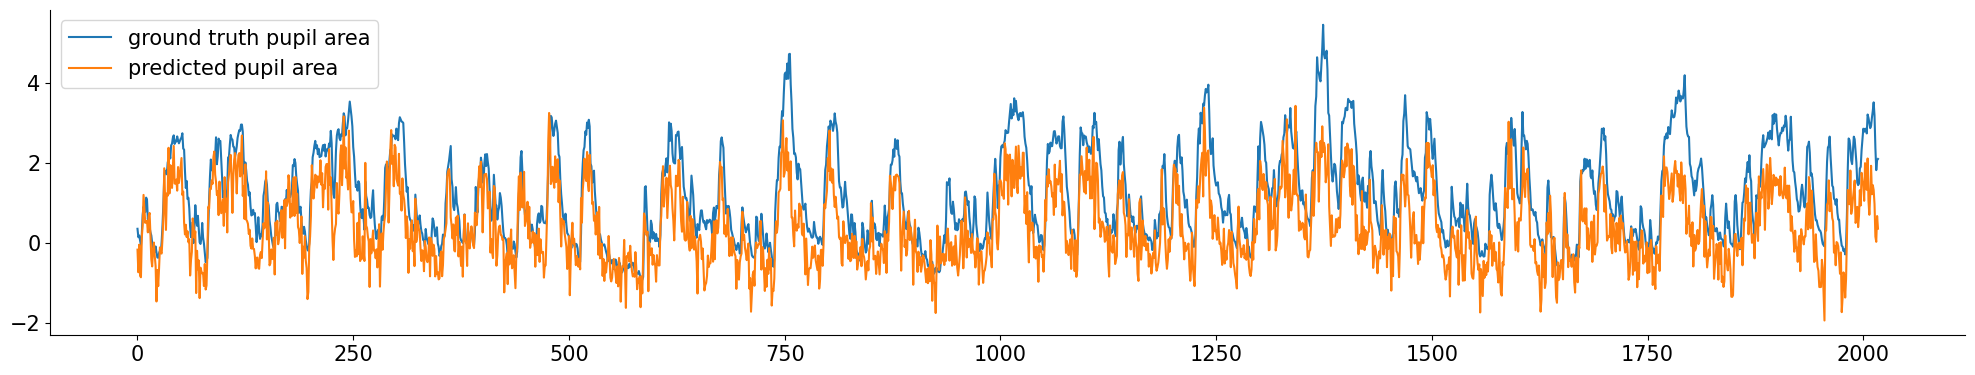

In [ ]:
pred_test_pupil_area = ridge_pupil_area_240.predict(test_neural_activity_240)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 210

In [ ]:
train_neural_activity_210 = neural_activity_210.T[0:5000]
train_neural_activity_210.shape

(5000, 1218)

In [ ]:
test_neural_activity_210 = neural_activity_210.T[5000:]
test_neural_activity_210.shape

(2018, 1218)

In [ ]:
ridge_decoder_pupilArea_210 = Pipeline([('Scaler',StandardScaler()),
                                        ('pca',PCA(n_components=1000)),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_210 = GridSearchCV(ridge_decoder_pupilArea_390,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_210.fit(train_neural_activity_210,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_210 = Ridge_pupil_area_gs_210.best_estimator_
ridge_pupil_area_210

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  1.039608420591259


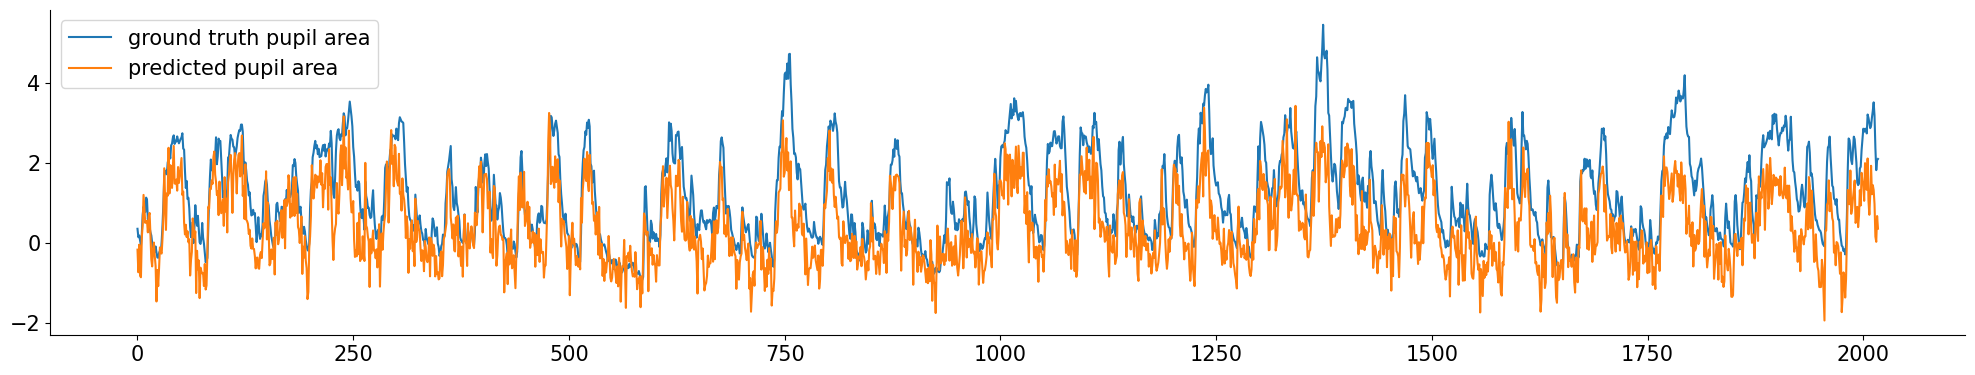

In [ ]:
pred_test_pupil_area = ridge_pupil_area_210.predict(test_neural_activity_210)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 180

In [ ]:
train_neural_activity_180 = neural_activity_180.T[0:5000]
train_neural_activity_180.shape

(5000, 1183)

In [ ]:
test_neural_activity_180 = neural_activity_180.T[5000:]
test_neural_activity_180.shape

(2018, 1183)

In [ ]:
ridge_decoder_pupilArea_180 = Pipeline([('Scaler',StandardScaler()),
                                        ('pca',PCA(n_components=1000)),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_180 = GridSearchCV(ridge_decoder_pupilArea_180,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_180.fit(train_neural_activity_180,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_180 = Ridge_pupil_area_gs_180.best_estimator_
ridge_pupil_area_180

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  1.1637470509901173


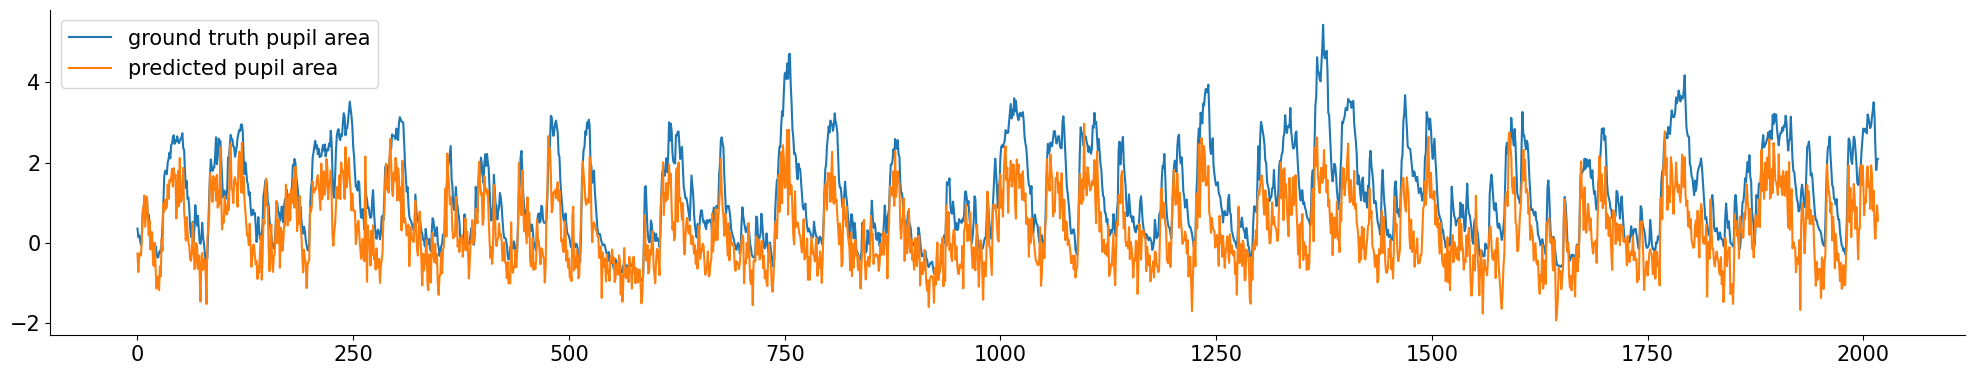

In [ ]:
pred_test_pupil_area = ridge_pupil_area_180.predict(test_neural_activity_180)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

#### 150

In [ ]:
train_neural_activity_150 = neural_activity_150.T[0:5000]
train_neural_activity_150.shape

(5000, 1132)

In [ ]:
test_neural_activity_150 = neural_activity_150.T[5000:]
test_neural_activity_150.shape

(2018, 1132)

In [ ]:
ridge_decoder_pupilArea_150 = Pipeline([('Scaler',StandardScaler()),
                                        ('pca',PCA(n_components=1000)),
                                    ('ridge_regressor', Ridge())])

params = {'ridge_regressor__alpha': [1300,1400,1500]}

Ridge_pupil_area_gs_150 = GridSearchCV(ridge_decoder_pupilArea_150,
                          param_grid=params,
                          cv=5,
                          scoring = 'neg_mean_squared_error',
                          refit=True)
Ridge_pupil_area_gs_150.fit(train_neural_activity_150,train_pupil_area)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('ridge_regressor', Ridge())]),
             param_grid={'ridge_regressor__alpha': [1300, 1400, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
ridge_pupil_area_150 = Ridge_pupil_area_gs_150.best_estimator_
ridge_pupil_area_150

Pipeline(steps=[('Scaler', StandardScaler()),
                ('ridge_regressor', Ridge(alpha=1500))])

mean square error on testing dataset:  1.2780995116885496


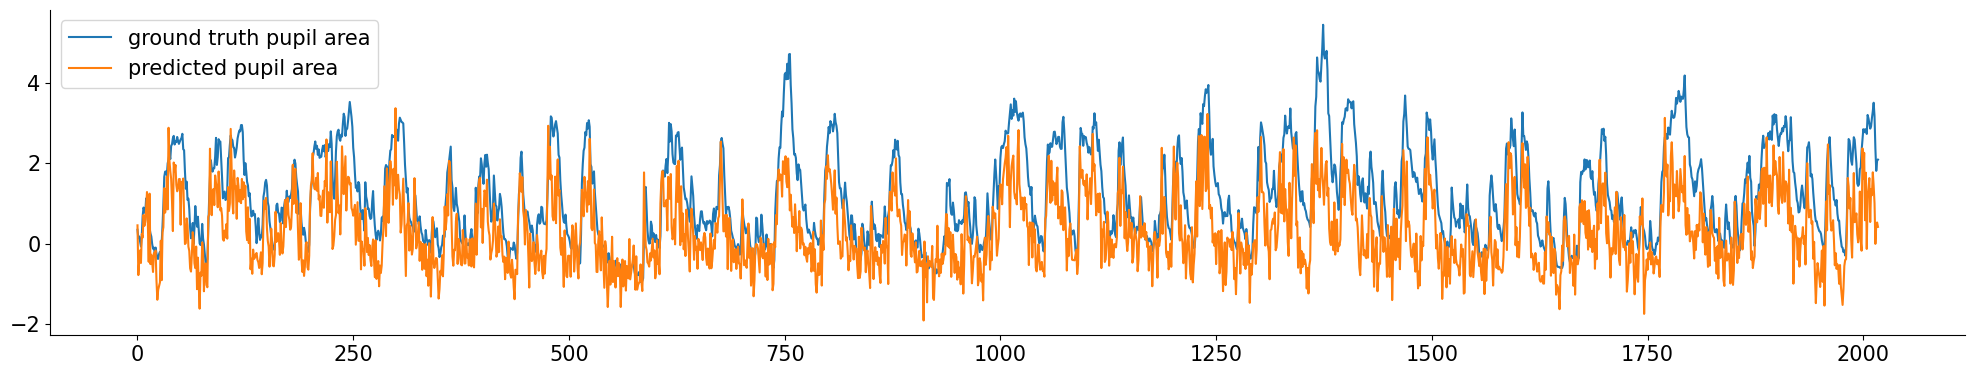

In [ ]:
pred_test_pupil_area = ridge_pupil_area_150.predict(test_neural_activity_150)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

## Non-linear decoder

In [ ]:
import tensorflow as tf

train_neural_activity_scaled = ridge_decoder_pupilArea.named_steps['Scaler'].fit_transform(train_neural_activity)
test_neural_activity_scaled = ridge_decoder_pupilArea.named_steps['Scaler'].transform(test_neural_activity)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (11983)),
    tf.keras.layers.Dense(100, activation='linear'),
    Dense(1, activation='linear', name='output_layer')
])
model_1.compile(loss = tf.keras.losses.MeanSquaredError(),
                optimizer = 'Adam',
                metrics = ['mse'])
model_1_history = model_1.fit(train_neural_activity_scaled,train_pupil_area, epochs = 20, validation_split = 0.3)

Epoch 1/20
110/110 [==============================] - 3s 6ms/step - loss: 25.2450 - mse: 25.2450 - val_loss: 9.8937 - val_mse: 9.8937
Epoch 2/20
110/110 [==============================] - 0s 4ms/step - loss: 5.3680 - mse: 5.3680 - val_loss: 0.7325 - val_mse: 0.7325
Epoch 3/20
110/110 [==============================] - 1s 6ms/step - loss: 0.5192 - mse: 0.5192 - val_loss: 0.3122 - val_mse: 0.3122
Epoch 4/20
110/110 [==============================] - 1s 7ms/step - loss: 0.1047 - mse: 0.1047 - val_loss: 0.2634 - val_mse: 0.2634
Epoch 5/20
110/110 [==============================] - 1s 6ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.2563 - val_mse: 0.2563
Epoch 6/20
110/110 [==============================] - 1s 8ms/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.2496 - val_mse: 0.2496
Epoch 7/20
110/110 [==============================] - 1s 5ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.2554 - val_mse: 0.2554
Epoch 8/20
110/110 [==============================] - 1s 5ms/step - loss: 

64/64 [==============================] - 0s 5ms/step
mean square error on testing dataset:  0.8309809486617815


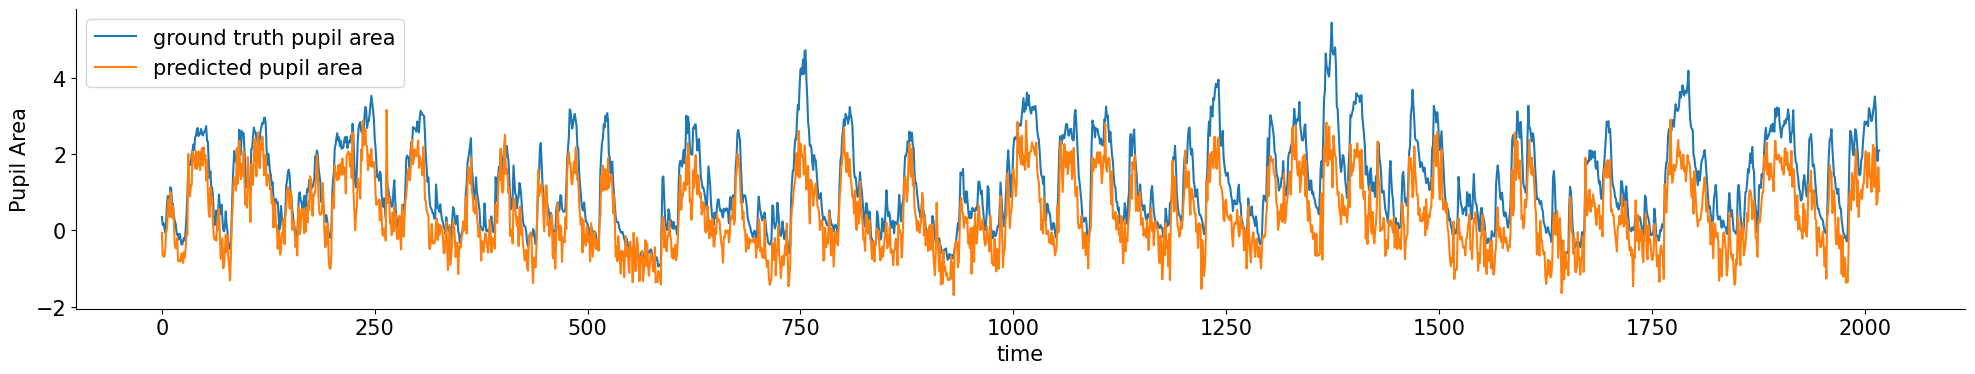

In [ ]:
pred_test_pupil_area = model_1.predict(test_neural_activity_scaled)
plt.figure()
plt.plot(test_pupil_area, label = 'ground truth pupil area')
plt.plot(pred_test_pupil_area, label = 'predicted pupil area')
plt.xlabel("time")
plt.ylabel("Pupil Area")
plt.legend()
print("mean square error on testing dataset: ", mean_squared_error(pred_test_pupil_area,test_pupil_area))

# Something about eye position (PupilCOM)

### Data observation

In [ ]:
dat['pupilCOM'][0].shape

(2,)

Text(0, 0.5, 'position')

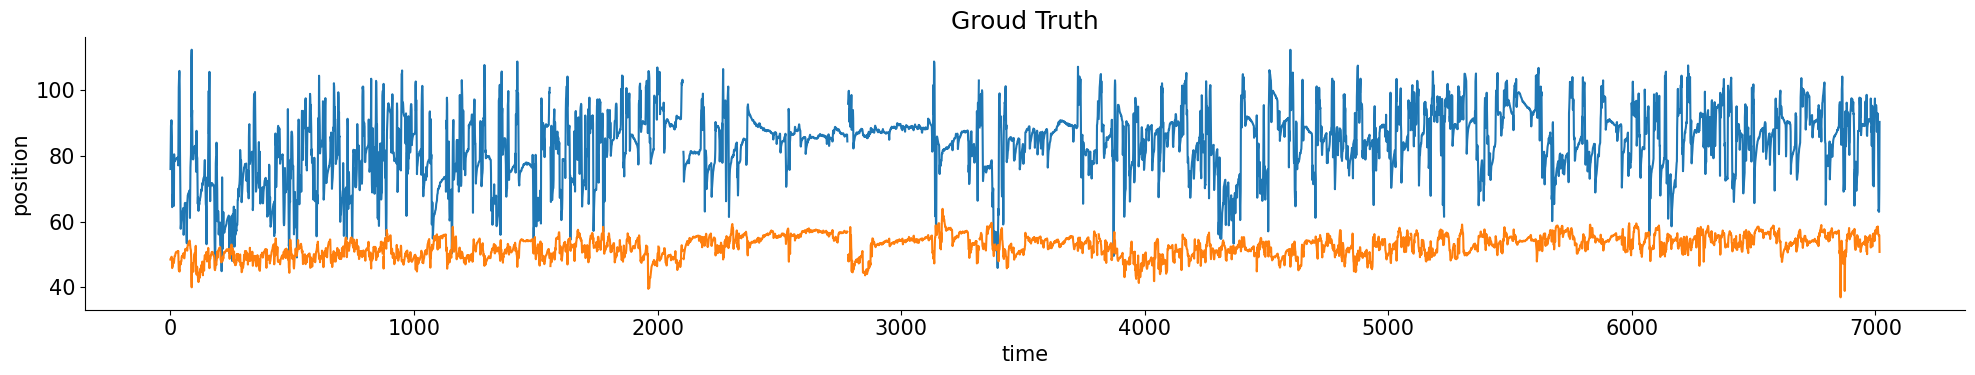

In [ ]:
plt.title("Groud Truth")
plt.plot(dat['pupilCOM'][:,0], label = " X position")
plt.plot(dat['pupilCOM'][:,1], label = " Y position")
plt.xlabel("time")
plt.ylabel("position")

In [ ]:
train_pupil_positon = dat['pupilCOM'][0:5000]
pupil_position_flag = train_pupil_positon[:,0] + train_pupil_positon[:,1]

train_neural_activity_cleaning = train_neural_activity[~np.isnan(pupil_position_flag),:]
train_pupil_positon_cleaning = train_pupil_positon[~np.isnan(pupil_position_flag),:]

train_neural_activity_cleaning.shape, train_pupil_positon_cleaning.shape

((4986, 11983), (4986, 2))

In [ ]:
Scaler_positon = StandardScaler()
train_pupil_positon_cleaning = Scaler_positon.fit_transform(train_pupil_positon_cleaning)

In [ ]:
test_neural_activity = dat['sresp'][:,5000:].T
test_pupil_position = dat['pupilCOM'][5000:]

test_pupil_position_flag = test_pupil_position[:,0] + test_pupil_position[:,1]
test_pupil_position_flag.shape
test_pupil_position_cleaning = test_pupil_position[~np.isnan(test_pupil_position_flag),:]
test_neural_activity_cleaning = test_neural_activity[~np.isnan(test_pupil_position_flag),:]

test_neural_activity_cleaning.shape, test_pupil_position_cleaning.shape

((2015, 11983), (2015, 2))

In [ ]:
test_pupil_position_cleaning = Scaler_positon.transform(test_pupil_position_cleaning)

### Train a Linear Decoder with multiple output

In [ ]:
linear_decoder_pupilposition = Pipeline([('Scaler',StandardScaler()),
                                         ('pca',PCA(n_components=1000)),
                                    ('linear_regressor', LinearRegression())])

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
multi_linear_regre = MultiOutputRegressor(linear_decoder_pupilposition)

In [ ]:
#train_pupil_positon[0]
multi_linear_regre = multi_linear_regre.fit(train_neural_activity_cleaning,train_pupil_positon_cleaning)

### Test on Training Dataset

In [ ]:
pred_train_position = multi_linear_regre.predict(train_neural_activity_cleaning)
pred_train_position.shape

(4986, 2)

AttributeError: ignored

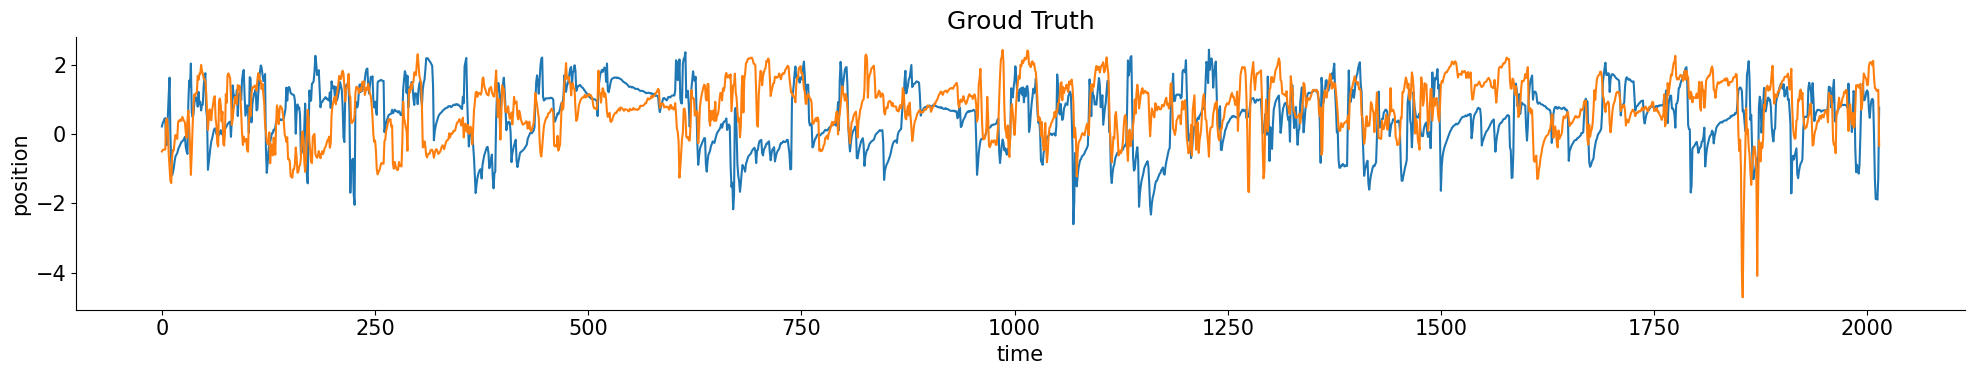

In [ ]:
plt.title("Groud Truth")
plt.plot(test_pupil_position_cleaning[:,0], label = " X position")
plt.plot(test_pupil_position_cleaning[:,1], label = " Y position")
plt.xlabel("time")
plt.ylabel("position")
p

NameError: ignored

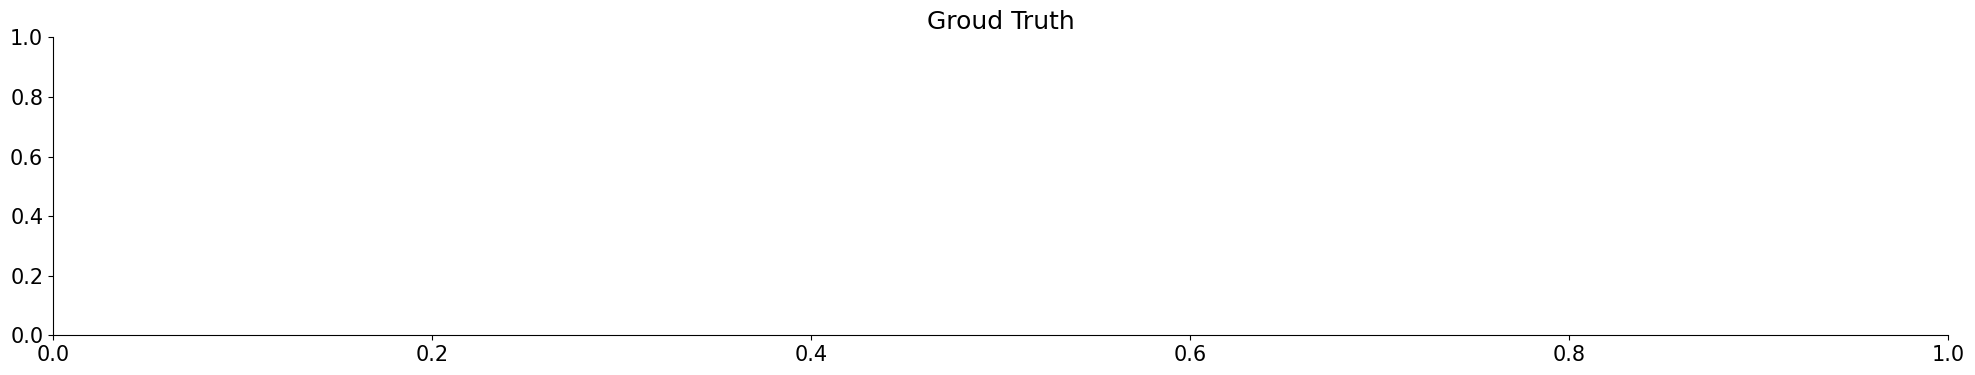

In [ ]:
plt.title("Groud Truth")
plt.plot(pred_train_position[:,0], label = " X position")
plt.plot(pred_train_position[:,1], label = " Y position")
plt.xlabel("time")
plt.ylabel("position")

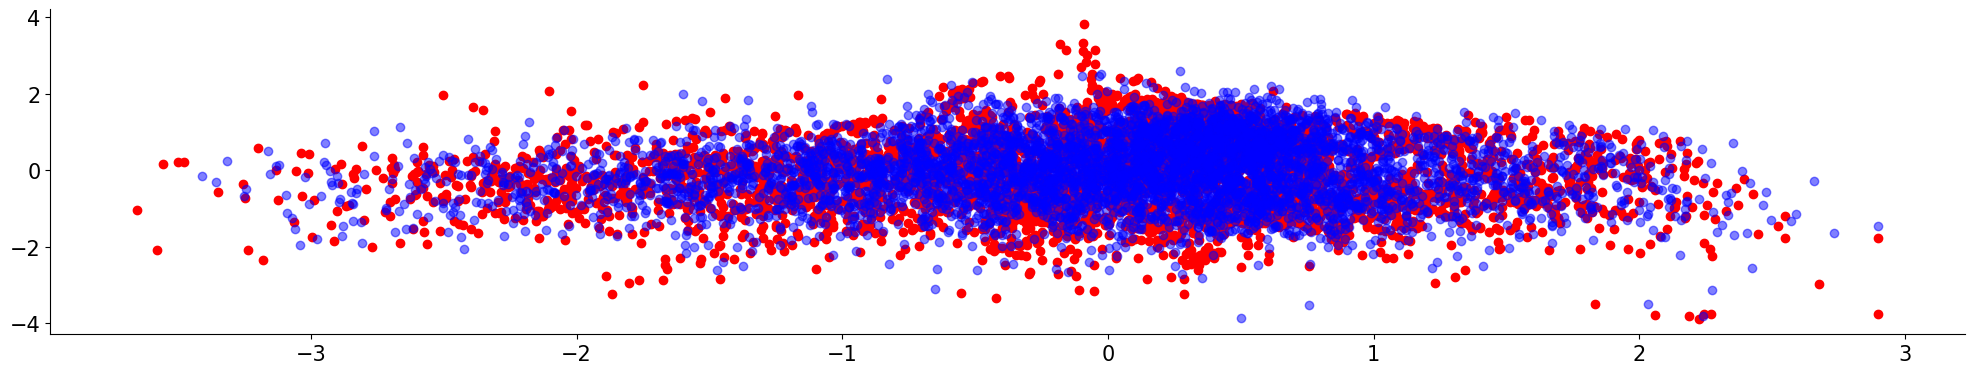

In [ ]:
plt.figure()
plt.scatter(train_pupil_positon_cleaning[:,0],train_pupil_positon_cleaning[:,1], c = 'r')
plt.scatter(pred_train_position[:,0],pred_train_position[:,1],c = 'b', alpha = 0.5)

MSE Formula:

$MSE = \frac{1}{n}\sum_{i=1}^n (x - {x}')^2 + (y - {y}')^2$

Where n is the total number of samples, x,y are the two-dimensional position, x',y' is predicted position.

In [ ]:
mse = np.sum((train_pupil_positon_cleaning - pred_train_position)**2)/train_pupil_positon_cleaning.shape[0]
print("the MSE in the training dataset is: ", mse)

the MSE in the training dataset is:  0.31832561554587985


### test on testing dataset

In [ ]:
pred_test_position = multi_linear_regre.predict(test_neural_activity_cleaning)
test_pupil_position_cleaning.shape

(2015, 2)

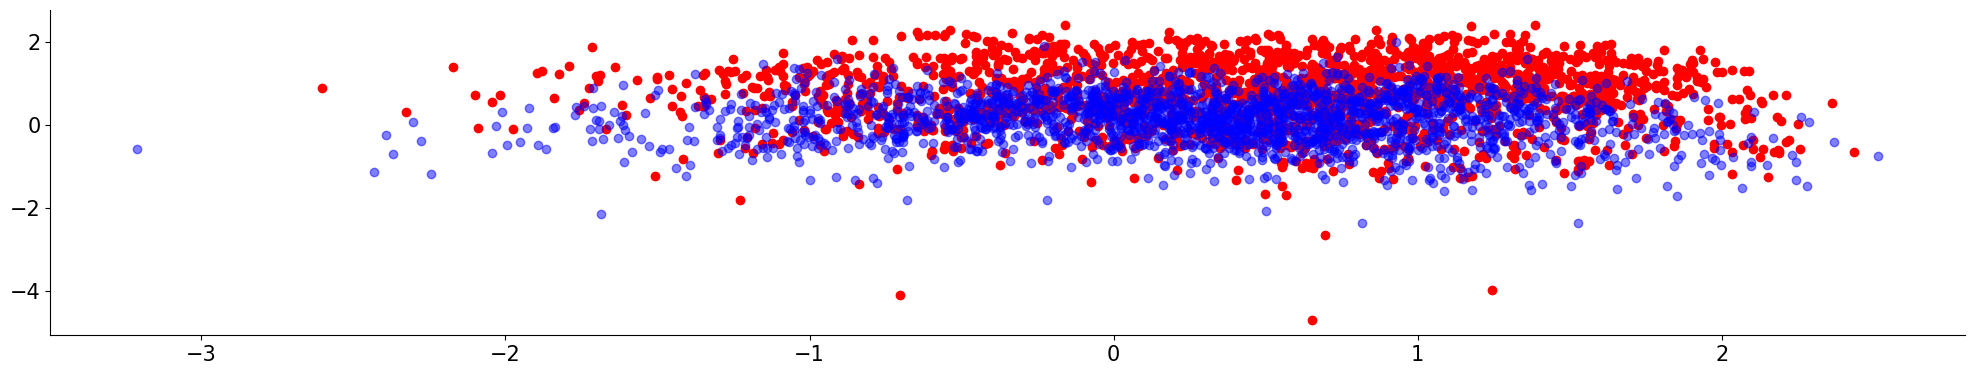

In [ ]:
plt.figure()
plt.scatter(test_pupil_position_cleaning[:,0],test_pupil_position_cleaning[:,1], c = 'r')
plt.scatter(pred_test_position[:,0],pred_test_position[:,1],c = 'b', alpha = 0.5)

In [ ]:
mse = np.sum((test_pupil_position_cleaning - pred_test_position)**2)/test_pupil_position_cleaning.shape[0]
print("the MSE in the training dataset is: ", mse)

the MSE in the training dataset is:  0.9120527382490353


Text(0, 0.5, 'position')

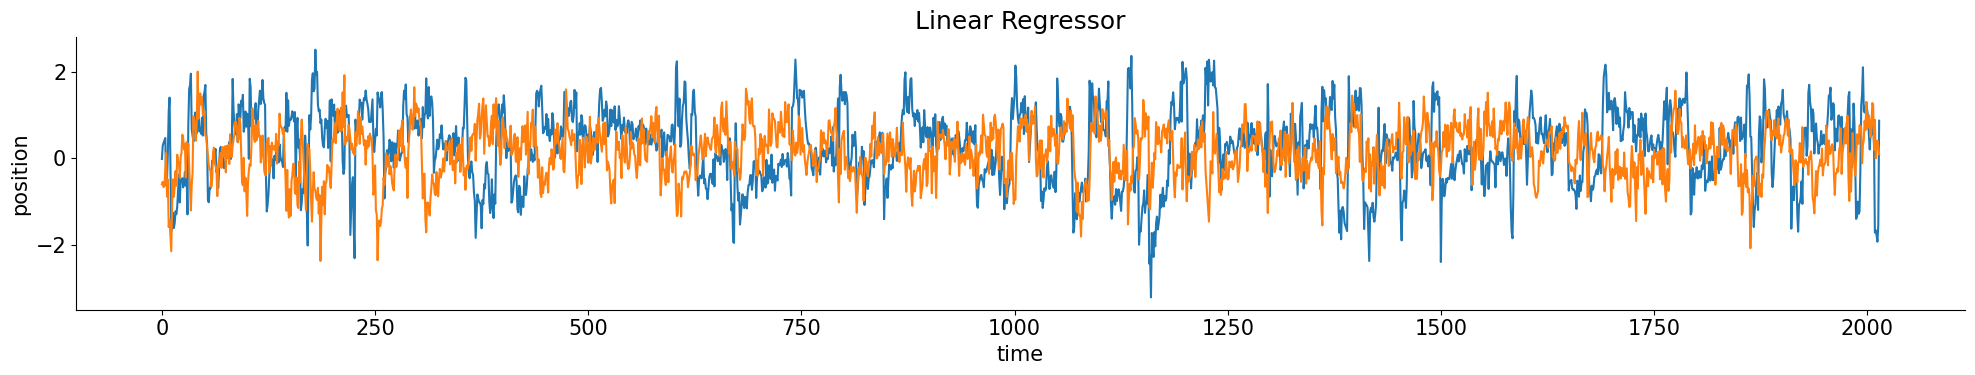

In [ ]:
plt.title("Linear Regressor")
plt.plot(pred_test_position[:,0], label = " X position")
plt.plot(pred_test_position[:,1], label = " Y position")
plt.xlabel("time")
plt.ylabel("position")

## Non-Linear

In [ ]:
import tensorflow as tf

train_neural_activity_scaled = ridge_decoder_pupilArea.named_steps['Scaler'].fit_transform(train_neural_activity)
test_neural_activity_scaled = ridge_decoder_pupilArea.named_steps['Scaler'].transform(test_neural_activity)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (11983)),
    tf.keras.layers.Dense(100, activation='linear'),
    Dense(2, activation='linear', name='output_layer')
])
model_1.compile(loss = tf.keras.losses.MeanSquaredError(),
                optimizer = 'Adam',
                metrics = ['mse'])
model_1_history = model_1.fit(train_neural_activity_cleaning,train_pupil_positon_cleaning, epochs = 20, validation_split = 0.3)

Epoch 1/20
110/110 [==============================] - 2s 7ms/step - loss: 441568.3125 - mse: 441568.3125 - val_loss: 51314.6797 - val_mse: 51314.6797
Epoch 2/20
110/110 [==============================] - 0s 4ms/step - loss: 29684.2031 - mse: 29684.2031 - val_loss: 67228.6484 - val_mse: 67228.6484
Epoch 3/20
110/110 [==============================] - 0s 4ms/step - loss: 62783.3242 - mse: 62783.3242 - val_loss: 47536.3594 - val_mse: 47536.3594
Epoch 4/20
110/110 [==============================] - 1s 5ms/step - loss: 55659.2773 - mse: 55659.2773 - val_loss: 190593.1719 - val_mse: 190593.1719
Epoch 5/20
110/110 [==============================] - 1s 5ms/step - loss: 32413.9160 - mse: 32413.9160 - val_loss: 51053.9609 - val_mse: 51053.9609
Epoch 6/20
110/110 [==============================] - 0s 4ms/step - loss: 16570.7305 - mse: 16570.7305 - val_loss: 30008.4648 - val_mse: 30008.4648
Epoch 7/20
110/110 [==============================] - 0s 4ms/step - loss: 8535.6084 - mse: 8535.6084 - val_l

In [ ]:
##

# Motion energy

In [ ]:
dat['beh_svd_mask'].shape, dat['beh_svd_time'].shape

((240, 320, 1000), (7018, 1000))

In [ ]:
motion_eng = (dat['beh_svd_mask'] @ dat['beh_svd_time'].T)



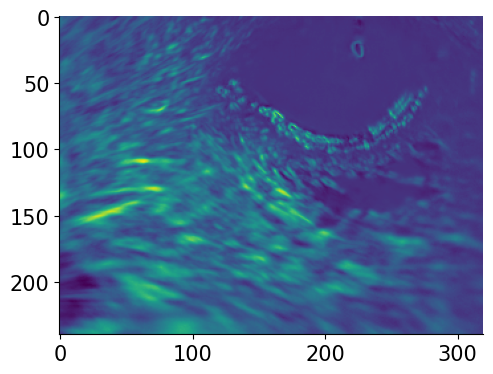

In [ ]:
plt.imshow(motion_eng[:,:,1])

In [ ]:
 dat['beh_svd_time'].shape

 train_behav = dat['beh_svd_time'][0:5000]
 test_behav = dat['beh_svd_time'][5000:]

In [ ]:
Scaler_behav = StandardScaler()
train_behav = Scaler_behav.fit_transform(train_behav)
test_behav = Scaler_behav.transform(test_behav)

## Linear

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
linear_decoder_behav = Pipeline([('Scaler',StandardScaler()),
                                  ('pca',PCA(n_components=1000)),
                                    ('linear_regressor', LinearRegression())])

In [ ]:
linear_decoder_behav.fit(train_neural_activity,train_behav)

Pipeline(steps=[('Scaler', StandardScaler()), ('pca', PCA(n_components=1000)),
                ('linear_regressor', LinearRegression())])

In [ ]:
pred_behav = linear_decoder_behav.predict(test_neural_activity)
pred_behav_train = linear_decoder_behav.predict(train_neural_activity)

In [ ]:
print("mse(behave): ", mean_squared_error(pred_behav, test_behav))
print("mse(behave): ", mean_squared_error(pred_behav_train, train_behav))

mse(behave):  1.1861872125825714
mse(behave):  0.731787856095377


## Non-linear

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import keras

In [ ]:
train_neural_activity_scaled = linear_decoder_behav.named_steps['Scaler'].transform(train_neural_activity)

test_neural_activity_scaled = linear_decoder_behav.named_steps['Scaler'].transform(test_neural_activity)


In [ ]:
import tensorflow as tf

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (11983)),
    tf.keras.layers.Dense(100, activation='linear'),
    Dense(1000, activation='linear', name='output_layer')
])
model_1.compile(loss = tf.keras.losses.MeanSquaredError(),
                optimizer = 'Adam',
                metrics = ['mse'])
model_1_history = model_1.fit(train_neural_activity_scaled,train_behav, epochs = 50, validation_split = 0.3)

Epoch 1/50
110/110 [==============================] - 3s 10ms/step - loss: 1.2138 - mse: 1.2138 - val_loss: 1.0457 - val_mse: 1.0457
Epoch 2/50
110/110 [==============================] - 1s 7ms/step - loss: 0.9470 - mse: 0.9470 - val_loss: 1.0599 - val_mse: 1.0599
Epoch 3/50
110/110 [==============================] - 1s 7ms/step - loss: 0.8415 - mse: 0.8415 - val_loss: 1.1210 - val_mse: 1.1210
Epoch 4/50
110/110 [==============================] - 1s 7ms/step - loss: 0.7737 - mse: 0.7737 - val_loss: 1.1709 - val_mse: 1.1709
Epoch 5/50
110/110 [==============================] - 1s 5ms/step - loss: 0.7384 - mse: 0.7384 - val_loss: 1.2033 - val_mse: 1.2033
Epoch 6/50
110/110 [==============================] - 1s 5ms/step - loss: 0.7199 - mse: 0.7199 - val_loss: 1.2128 - val_mse: 1.2128
Epoch 7/50
110/110 [==============================] - 1s 5ms/step - loss: 0.7171 - mse: 0.7171 - val_loss: 1.2201 - val_mse: 1.2201
Epoch 8/50
110/110 [==============================] - 1s 5ms/step - loss: 0

In [ ]:
model_1.evaluate(test_neural_activity_scaled,test_behav)

64/64 [==============================] - 0s 3ms/step - loss: 1.4120 - mse: 1.4120


[1.411978006362915, 1.411978006362915]

In [ ]:
predicted_motion_energy = model_1.predict(test_neural_activity_scaled)
predicted_motion_energy,test_behav

64/64 [==============================] - 0s 2ms/step


(array([[ 0.35216513,  0.3245836 ,  0.18121666, ..., -0.36537787,
          0.52556163,  0.00567834],
        [ 0.2157444 ,  0.47127855, -1.3633527 , ..., -0.26472908,
         -0.3078445 ,  0.24862361],
        [ 0.03917447,  1.0653177 , -0.1407841 , ...,  0.06761961,
         -0.10181213, -0.01568597],
        ...,
        [ 0.30318657, -0.5119257 ,  0.419344  , ..., -0.1710577 ,
         -0.30709428, -0.57988715],
        [-1.2023662 , -0.44532296, -0.13828379, ..., -0.36165178,
         -0.14533444, -0.12354776],
        [-2.969041  ,  1.3681825 ,  1.5085543 , ...,  0.22290751,
          0.3997723 , -0.44244805]], dtype=float32),
 array([[ 0.60534512,  0.35579921, -0.35841033, ...,  0.30283045,
         -0.2808902 , -0.54938407],
        [ 0.62274616,  0.27708639, -0.25354638, ...,  0.77370527,
          0.25884404, -0.67781291],
        [ 0.54573582,  0.56615869, -0.67548586, ...,  0.63996058,
          0.20459444, -0.44611424],
        ...,
        [ 0.04806744, -0.61000187, -0.3

In [ ]:
predicted_motion_energy_train = model_1.predict(train_neural_activity_scaled)

157/157 [==============================] - 0s 3ms/step


In [ ]:
print("mse(behave): ", mean_squared_error(predicted_motion_energy, test_behav))
print("mse(behave): ", mean_squared_error(predicted_motion_energy_train, train_behav))
#predicted_motion_energy.shape,test_behav.shape

mse(behave):  1.4006086987855437
mse(behave):  0.8128298381621353


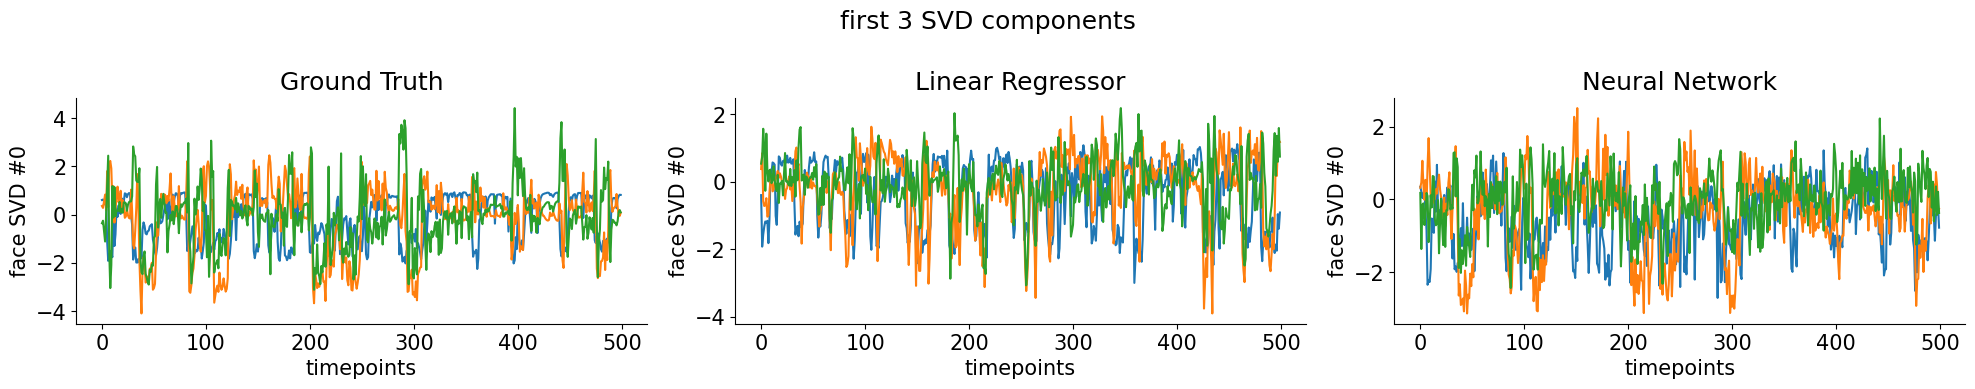

In [ ]:
plt.suptitle("first 3 SVD components")
ax = plt.subplot(1, 3, 1)
plt.title("Ground Truth")
plt.plot(test_behav[:500, 0])
plt.plot(test_behav[:500, 1])
plt.plot(test_behav[:500, 2])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

ax = plt.subplot(1, 3, 2)
plt.title("Linear Regressor")
plt.plot(pred_behav_train[:500, 0])
plt.plot(pred_behav_train[:500, 1])
plt.plot(pred_behav_train[:500, 2])
ax.set(xlabel='timepoints', ylabel='face SVD #0')


ax = plt.subplot(1, 3, 3)
plt.title("Neural Network")
plt.plot(predicted_motion_energy[:500, 0])
plt.plot(predicted_motion_energy[:500, 1])
plt.plot(predicted_motion_energy[:500, 2])
ax.set(xlabel='timepoints', ylabel='face SVD #0')

plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Define the features to cluster
features_to_cluster = predicted_motion_energy
# Preprocess the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_cluster)

# Define the number of clusters
n_clusters = 2

# Cluster the data using K-Means algorithm
kmeans = KMeans(n_clusters=n_clusters,init = 'random', random_state=0).fit(scaled_features)

# Compute the silhouette score
silhouette_avg = silhouette_score(scaled_features, kmeans.labels_, metric='euclidean')
print(f'Silhouette score for {n_clusters} clusters: {silhouette_avg:.2f}')

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette score for 2 clusters: 0.09


In [ ]:
clust = KMeans(n_clusters = 3).fit_predict(predicted_motion_energy)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
np.unique(clust,return_counts=True)

(array([0, 1, 2], dtype=int32), array([1480,  216,  322]))

In [ ]:
largest_prediction = predicted_motion_energy[np.where(clust == 0)]
largest_prediction.shape

(1480, 1000)

<ipython-input-301-c7c855d315ab>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(largest_prediction[:, 0], largest_prediction[:, 1], s=1,c=clust[[np.where(clust == 0)]])


Text(0, 0.5, 'SVD Component #1')

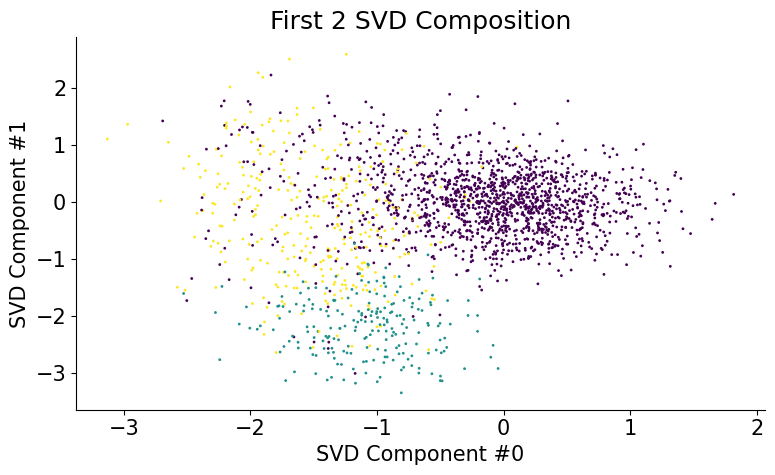

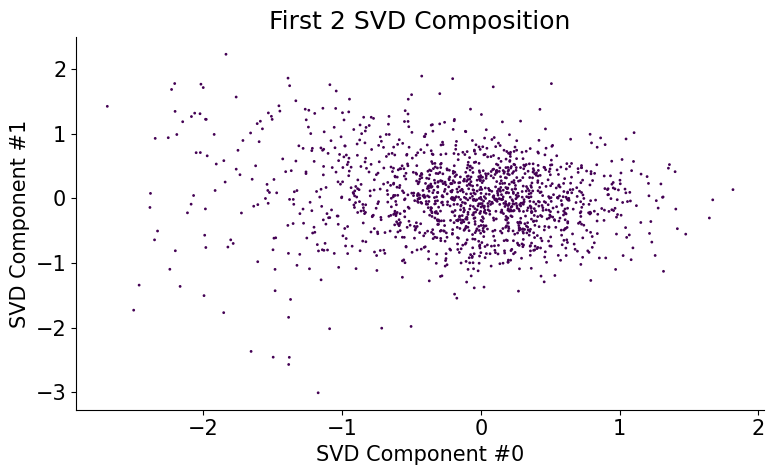

In [ ]:

plt.figure(figsize = (8,5))
plt.title("First 2 SVD Composition")

plt.scatter(predicted_motion_energy[:, 0], predicted_motion_energy[:, 1], s=1,c=clust)
plt.xlabel("SVD Component #0")
plt.ylabel("SVD Component #1")

plt.figure(figsize = (8,5))
plt.title("First 2 SVD Composition")
plt.scatter(largest_prediction[:, 0], largest_prediction[:, 1], s=1,c=clust[[np.where(clust == 0)]])
plt.xlabel("SVD Component #0")
plt.ylabel("SVD Component #1")


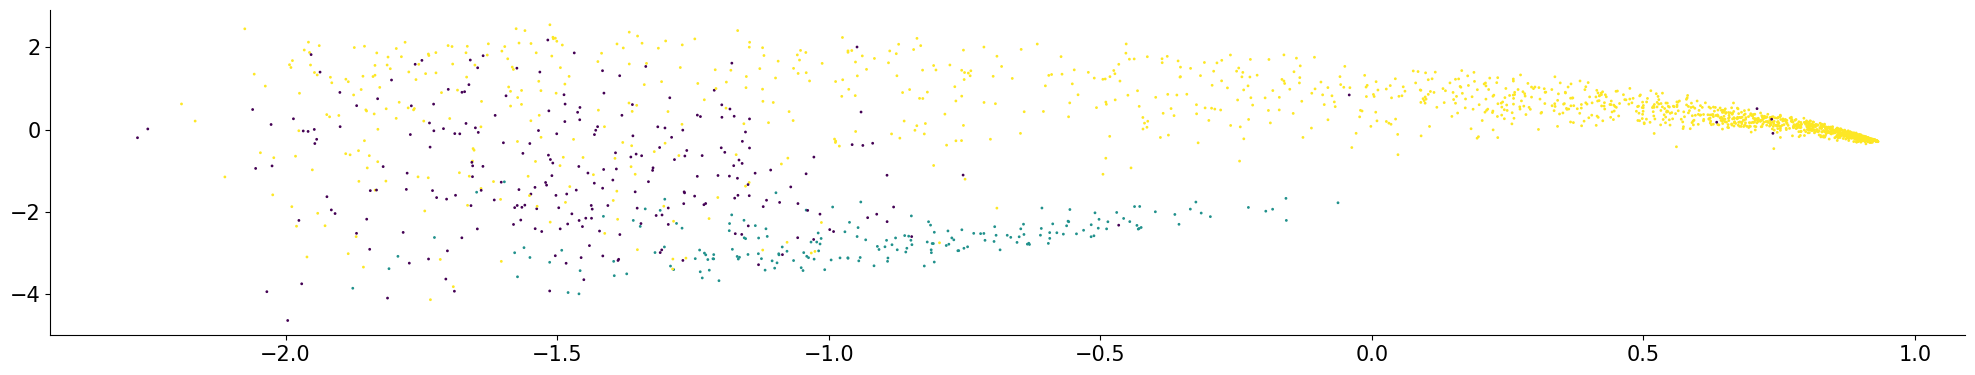

In [ ]:
plt.scatter(test_behav[:, 0], test_behav[:, 1], s=1,c=clust)

In [ ]:
clust = KMeans(n_clusters = 3).fit_predict(pred_behav)
np.unique(clust,return_counts=True)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0, 1, 2], dtype=int32), array([ 239, 1567,  212]))

<ipython-input-303-a9f38e487073>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(largest_prediction[:, 0], largest_prediction[:, 1], s=1,c=clust[[np.where(clust ==1)]])


Text(0, 0.5, 'SVD Component #1')

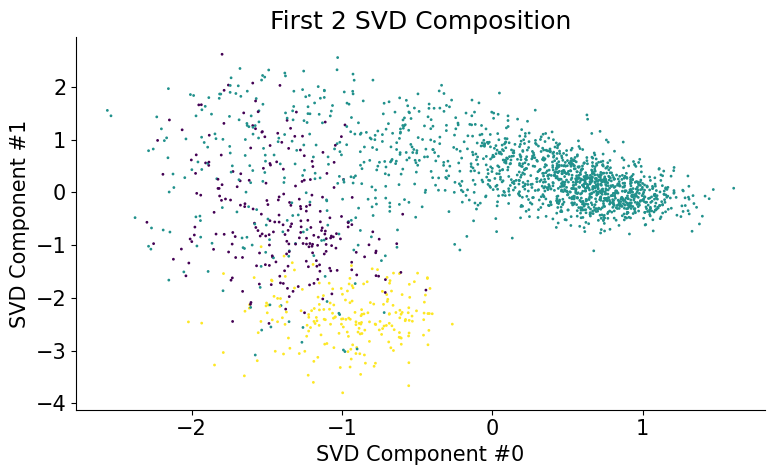

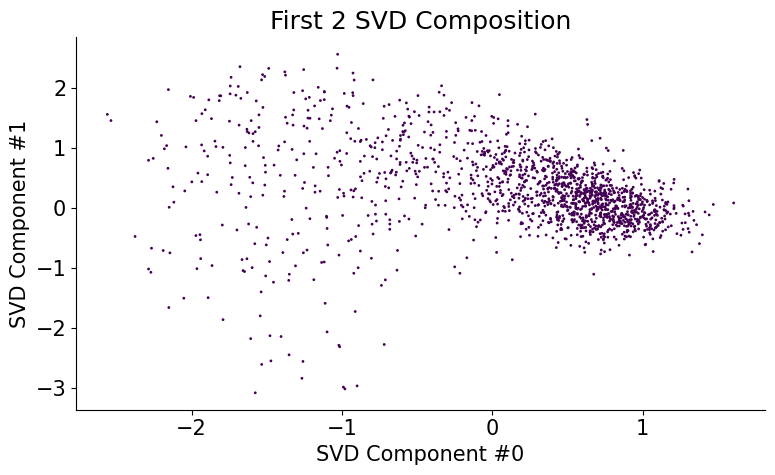

In [ ]:
largest_prediction = pred_behav[np.where(clust == 1)]
plt.figure(figsize = (8,5))
plt.title("First 2 SVD Composition")
plt.scatter(pred_behav[:, 0], pred_behav[:, 1], s=1,c=clust)
plt.xlabel("SVD Component #0")
plt.ylabel("SVD Component #1")

plt.figure(figsize = (8,5))
plt.title("First 2 SVD Composition")
plt.scatter(largest_prediction[:, 0], largest_prediction[:, 1], s=1,c=clust[[np.where(clust ==1)]])
plt.xlabel("SVD Component #0")
plt.ylabel("SVD Component #1")


In [ ]:
clust = KMeans(n_clusters = 3).fit_predict(test_behav)
np.unique(clust,return_counts=True)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0, 1, 2], dtype=int32), array([ 618, 1394,    6]))

<ipython-input-304-d0bbfd5f1363>:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(largest_prediction[:, 0], largest_prediction[:, 1], s=1,c=clust[[np.where(clust ==1)]])


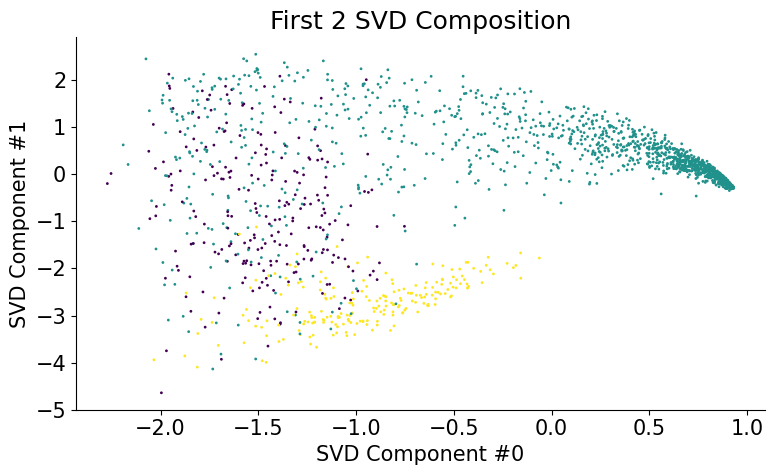

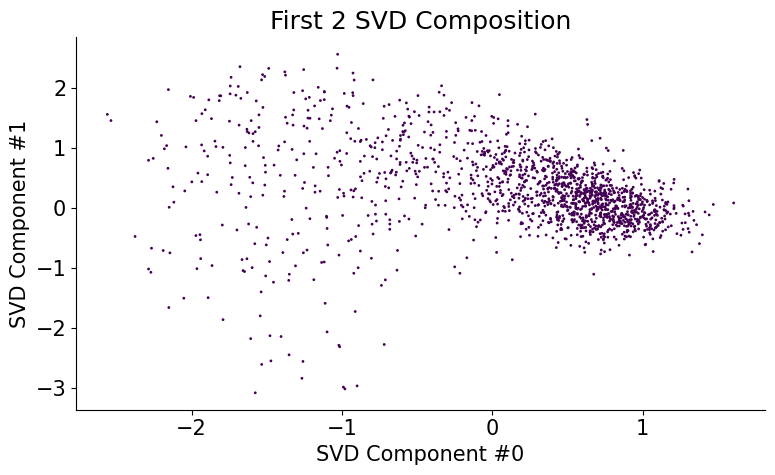

In [ ]:
largest_prediction = pred_behav[np.where(clust == 1)]
plt.figure(figsize = (8,5))
plt.title("First 2 SVD Composition")
plt.xlabel("SVD Component #0")
plt.ylabel("SVD Component #1")

plt.scatter(test_behav[:, 0], test_behav[:, 1], s=1,c=clust)

plt.figure(figsize = (8,5))
plt.title("First 2 SVD Composition")
plt.xlabel("SVD Component #0")
plt.ylabel("SVD Component #1")
plt.scatter(largest_prediction[:, 0], largest_prediction[:, 1], s=1,c=clust[[np.where(clust ==1)]])